# ID5059 2022-23: Coursework Assignment 1

## Acknowledgments

This assignment is loosely based on the first assignment set by [Tom Kelsey](https://www.st-andrews.ac.uk/computer-science/people/twk/) in the 2020-21 delivery of ID5059. It uses data from the [Flight status prediction dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022) on [Kaggle](https://www.kaggle.com), posted by [Rob Mulla](https://www.linkedin.com/in/rob-mulla/).

### Get the data

This notebook is just intended to get you started: it includes enough to load one of the small datasets.

In [1]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn us category_encoders | grep -v 'already satisfied'

import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import us
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn import tree
from category_encoders import TargetEncoder


Defaulting to user installation because normal site-packages is not writeable


Using legacy 'setup.py install' for us, since package 'wheel' is not installed.
  distutils: /home/ejml1/.local/lib/python3.9/site-packages
  sysconfig: /home/ejml1/.local/lib64/python3.9/site-packages
  user = True
  home = None
  root = None
  prefix = None
    Running setup.py install for us: started
    Running setup.py install for us: finished with status 'done'


/tmp/ipykernel_4052/1784018844.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


Various parts of the dataset are [available on the CS teaching servers](https://wiki.cs.st-andrews.ac.uk/index.php?title=Teaching_Service) at the [following path](/cs/datasets/ID5059/Coursework1/). For the [small](/cs/datasets/ID5059/Coursework1/1_small) and [medium](/cs/datasets/ID5059/Coursework1/2_medium) files there's no harm in downloading them to your laptop or to your filespace in the lab, if that's convenient.

For the [large](/cs/datasets/ID5059/Coursework1/3_large) and [huge](/cs/datasets/ID5059/Coursework1/4_huge) files, you **must not download them to your filespace on the School servers**. If everyone does this it will take up too much disk space. This applies whether you are using a machine in the lab, or connecting to a School server from your laptop.

Instead, you must access such files directly from studres, e.g. at:

```/cs/datasets/ID5059/Coursework1/3_large/Combined_Flights_large_train_2022.csv```

If you want to download large files to the disk on your own laptop, that's up to you!

In [2]:
# files = ["/cs/datasets/ID5059/Coursework1/2_medium/Combined_Flights_med_2018.csv",
#          "/cs/datasets/ID5059/Coursework1/2_medium/Combined_Flights_med_2019.csv",
#          "/cs/datasets/ID5059/Coursework1/2_medium/Combined_Flights_med_2020.csv",
#          "/cs/datasets/ID5059/Coursework1/2_medium/Combined_Flights_med_2021.csv",
#          "/cs/datasets/ID5059/Coursework1/2_medium/Combined_Flights_med_2022.csv"]

# files = ["/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2018.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2019.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2020.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2021.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2022.csv"]

files = glob("/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_*.csv")

test_files = glob("/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_test_*.csv")

# test_files = ["/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_test_2018.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_test_2019.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_test_2020.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_test_2021.csv",
#          "/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_test_2022.csv"]


flights = pandas.concat((pandas.read_csv(file) for file in files), ignore_index=True)

flights_test = pandas.concat((pandas.read_csv(file) for file in test_files), ignore_index=True)


# flights = pandas.concat(map(pandas.read_csv, files))

# flights_test = pandas.concat(map(pandas.read_csv, test_files))

# split the data into training and testing datasets

# flights, flights_test = train_test_split(flights, test_size=0.2, random_state=0)

# Clear the maximum number of columns to be displayed, so that all will be visible.
pandas.set_option('display.max_columns', None)

display(flights)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrDel15,ArrTimeBlk,DistanceGroup,Disruption,Unnamed: 0,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,ActualElapsedTime,DepDel15,DepartureDelayGroups,TaxiOut,WheelsOff,WheelsOn,TaxiIn,ArrDelay,ArrivalDelayGroups,DivAirportLandings
0,2020-09-01,Comair Inc.,PHL,DAY,0,0,1905,111.0,477,2020,3,9,1,2,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N506AE,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,0.0,2000-2059,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-03,Comair Inc.,PHL,DAY,0,0,1905,111.0,477,2020,3,9,3,4,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N710PS,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,1.0,2000-2059,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-05,Comair Inc.,PHL,DAY,0,0,1905,111.0,477,2020,3,9,5,6,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N705PS,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,0.0,2000-2059,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-06,Comair Inc.,PHL,DAY,0,0,1905,111.0,477,2020,3,9,6,7,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N710PS,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,0.0,2000-2059,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-07,Comair Inc.,PHL,DAY,0,0,1905,111.0,477,2020,3,9,7,1,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N543EA,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,0.0,2000-2059,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23355023,2018-09-11,Air Wisconsin Airlines Corp,SCE,IAD,0,0,1445,61.0,133,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3839,ZW,20046,ZW,N437AW,3839,14711,1471105,34711,"State College, PA",PA,42,Pennsylvania,23,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,1400-1459,1546,0.0,1500-1559,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23355024,2018-09-11,Air Wisconsin Airlines Corp,IAD,GSO,0,0,1235,80.0,239,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3838,ZW,20046,ZW,N410AW,3838,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,11995,1199502,31995,"Greensboro/High Point, NC",NC,37,North Carolina,36,1200-1259,1355,0.0,1300-1359,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23355025,2018-09-11,Air Wisconsin Airlines Corp,EVV,ORD,0,0,1030,94.0,272,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N467AW,3837,11612,1161206,31612,"Evansville, IN",IN,18,Indiana,42,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,1000-1059,1204,0.0,1200-1259,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23355026,2018-09-11,Air Wisconsin Airlines Corp,ORD,HPN,0,0,1410,136.0,738,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3

Remove the disallowed columns as specified from the specification file

In [3]:
disallowed_columns = ["DepTime", "DepDelayMinutes", "DepDelay", "ArrTime", "ArrDelayMinutes", "AirTime", "ActualElapsedTime",
                      "DepDel15", "DepartureDelayGroups", "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn", "ArrDelay", 
                      "ArrivalDelayGroups", "DivAirportLandings", "Cancelled", "Diverted", "ArrDel15"]


flights = flights.drop(columns=flights.columns.intersection(disallowed_columns))

# Explore Dataset

In [4]:
flights

,FlightDate,Airline,Origin,Dest,CRSDepTime,CRSElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrTimeBlk,DistanceGroup,Disruption,Unnamed: 0
0,2020-09-01,Comair Inc.,PHL,DAY,1905,111.0,477,2020,3,9,1,2,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N506AE,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,2000-2059,2,0.0,NaN
1,2020-09-03,Comair Inc.,PHL,DAY,1905,111.0,477,2020,3,9,3,4,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N710PS,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,2000-2059,2,1.0,NaN
2,2020-09-05,Comair Inc.,PHL,DAY,1905,111.0,477,2020,3,9,5,6,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N705PS,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,2000-2059,2,0.0,NaN
3,2020-09-06,Comair Inc.,PHL,DAY,1905,111.0,477,2020,3,9,6,7,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N710PS,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,2000-2059,2,0.0,NaN
4,2020-09-07,Comair Inc.,PHL,DAY,1905,111.0,477,2020,3,9,7,1,AA,AA_CODESHARE,19805,AA,5020,OH,20397,OH,N543EA,5020,14100,1410005,34100,"Philadelphia, PA",PA,42,Pennsylvania,23,11267,1126702,31267,"Dayton, OH",OH,39,Ohio,44,1900-1959,2056,2000-2059,2,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23355023,2018-09-11,Air Wisconsin Airlines Corp,SCE,IAD,1445,61.0,133,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3839,ZW,20046,ZW,N437AW,3839,14711,1471105,34711,"State College, PA",PA,42,Pennsylvania,23,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,1400-1459,1546,1500-1559,1,0.0,NaN
23355024,2018-09-11,Air Wisconsin Airlines Corp,IAD,GSO,1235,80.0,239,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3838,ZW,20046,ZW,N410AW,3838,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,11995,1199502,31995,"Greensboro/High Point, NC",NC,37,North Carolina,36,1200-1259,1355,1300-1359,1,0.0,NaN
23355025,2018-09-11,Air Wisconsin Airlines Corp,EVV,ORD,1030,94.0,272,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N467AW,3837,11612,1161206,31612,"Evansville, IN",IN,18,Indiana,42,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,1000-1059,1204,1200-1259,2,0.0,NaN
23355026,2018-09-11,Air Wisconsin Airlines Corp,ORD,HPN,1410,136.0,738,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N440AW,3837,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,12197,1219702,31703,"White Plains, NY",NY,36,New York,22,1400-1459,1726,1700-1759,3,0.0,NaN


In [5]:
flights.dtypes

FlightDate                                  object
Airline                                     object
Origin                                      object
Dest                                        object
CRSDepTime                                   int64
CRSElapsedTime                             float64
Distance                                     int64
Year                                         int64
Quarter                                      int64
Month                                        int64
DayofMonth                                   int64
DayOfWeek                                    int64
Marketing_Airline_Network                   object
Operated_or_Branded_Code_Share_Partners     object
DOT_ID_Marketing_Airline                     int64
IATA_Code_Marketing_Airline                 object
Flight_Number_Marketing_Airline              int64
Operating_Airline                           object
DOT_ID_Operating_Airline                     int64
IATA_Code_Operating_Airline    

Ensure that the Distribution attribute only has 2 values. If so, convert it into a boolean type

In [6]:
print("Disruption: ", len(flights["Disruption"].unique()))

Disruption:  3


In [7]:
# find the number of missing values in disruption
print("Missing values in Disruption: ", flights["Disruption"].isna().sum())

Missing values in Disruption:  6473797


In [8]:
flights = flights[flights["Disruption"].isin([0, 1])]

In [9]:
# Convert the Disruption column to boolean.
flights["Disruption"] = flights["Disruption"].astype(int).astype(bool)


/tmp/ipykernel_4052/2120323300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights["Disruption"] = flights["Disruption"].astype(int).astype(bool)


In [10]:
# Get disruption column type
flights["Disruption"].dtype

dtype('bool')

(array([0, 1]), [Text(0, 0, 'Not Disrupted'), Text(1, 0, 'Disrupted')])

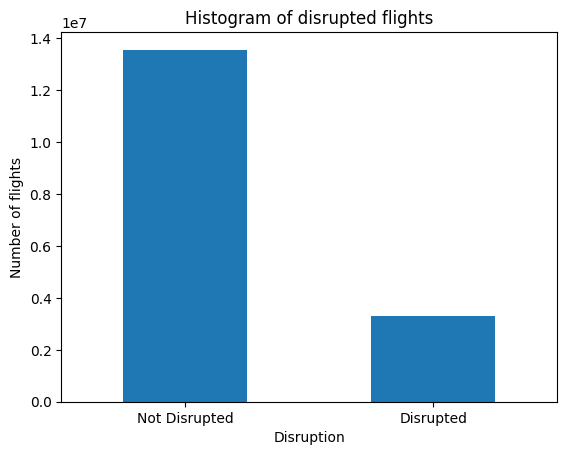

In [11]:
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights")
flights["Disruption"].value_counts().plot(kind="bar")
plt.xticks([0, 1], ["Not Disrupted", "Disrupted"])
plt.xticks(rotation=0)


In [12]:
disrupted = flights["Disruption"].value_counts()[1]

total = len(flights)

print("Percentage of disrupted flights: ", disrupted / total * 100, "%")

Percentage of disrupted flights:  19.66900399621331 %


/tmp/ipykernel_4052/3591043519.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  disrupted = flights["Disruption"].value_counts()[1]


The attributes that I have selected to explore are:
1. Year
2. Month
3. DayOfWeek
4. DepTimeBlk
5. ArrTimeBlk
6. Operating_Airline
7. Distance
8. OriginAirportID
9. DestAirportID
10. OriginState

## The effect of Covid-19 on flight disruption

(array([0, 1, 2, 3]),
 [Text(0, 0, '2018'),
  Text(1, 0, '2020'),
  Text(2, 0, '2021'),
  Text(3, 0, '2022')])

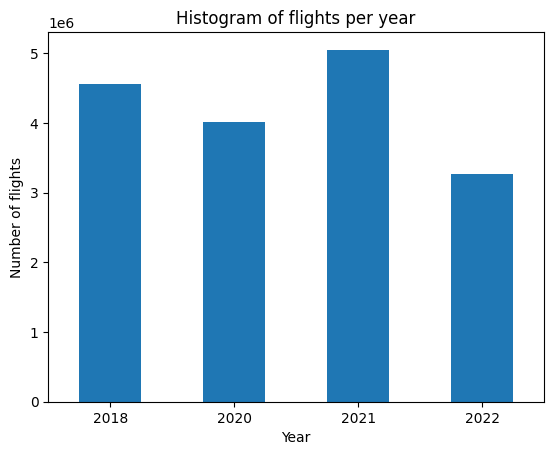

In [13]:
# Plot histogram of the number of flights per year
plt.ylabel("Number of flights")
plt.title("Histogram of flights per year")
flights["Year"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=0)

In [14]:
print(f'Months present in 2022: {sorted(flights[flights["Year"] == 2022]["Month"].unique())}')

Months present in 2022: [1, 2, 3, 4, 5, 6, 7]


In [15]:
print(f'Months present in 2018: {sorted(flights[flights["Year"] == 2022]["Month"].unique())}')

Months present in 2018: [1, 2, 3, 4, 5, 6, 7]


(array([0, 1, 2, 3]),
 [Text(0, 0, '2018'),
  Text(1, 0, '2020'),
  Text(2, 0, '2021'),
  Text(3, 0, '2022')])

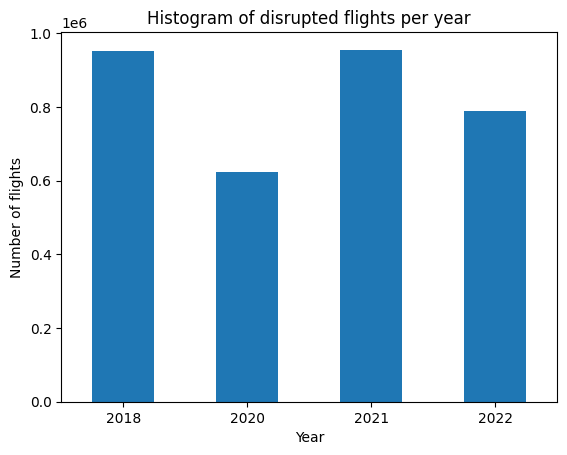

In [16]:
# plot number of disrupted flights per year
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights per year")
flights[flights["Disruption"] == 1]["Year"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=0)

(array([0, 1, 2, 3]),
 [Text(0, 0, '2018'),
  Text(1, 0, '2020'),
  Text(2, 0, '2021'),
  Text(3, 0, '2022')])

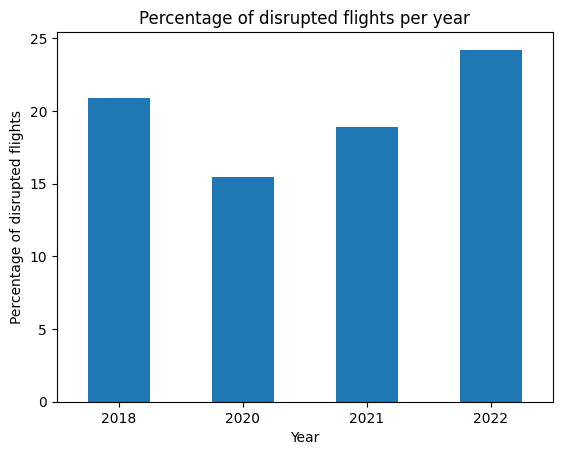

In [17]:
# Plot the percentage of disrupted flights per year
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights per year")
(flights[flights["Disruption"] == 1]["Year"].value_counts().sort_index() / flights["Year"].value_counts().sort_index() * 100).plot(kind="bar")
plt.xticks(rotation=0)

COVID observations:

- COVID appears to have decreased the number of flights in 2020 and 2021 in comparison to 2019
- Potentially due to the decrease in flights, the percentage of distrupted flights during this time is lower

Post COVID observations:
- The dataset ends on August 2022 so the number of flights has decreased in total but is at a similar level to covid years
- As regulations open back up, the percentage of distrupted flights in 2022 is high

Pre COVID observations:
- Despite having all the months present in the dataset for the year 2018, I am not sure the reasoning behind why there were a lot fewer flights in this year compared to 2019


Buisness Aim Considerations:

- Given that the aim is to predict future flights, including year as an attribute may be an issue as the classifier may see an increasing trend from 2020 onwards and predict that the disruptions grow linearily over time. This is most likely not true given the anomoly our world faced during this period. Thus if year was to be used as an attribute to predict time, it would make sense to group all future flights within the same category as 2022. 2022 would then represents itself and all future years passed through to the model. I believe this makes the most sense as we are still in a world that is living post COVID and the data from 2022 is my best guess to what the best representation of what the near future would like.

## Explore the effect of Month on Disruption

- A quarter within a year may not capture the affect certain months have on distruption, thus choosing month may capture the granularity better

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

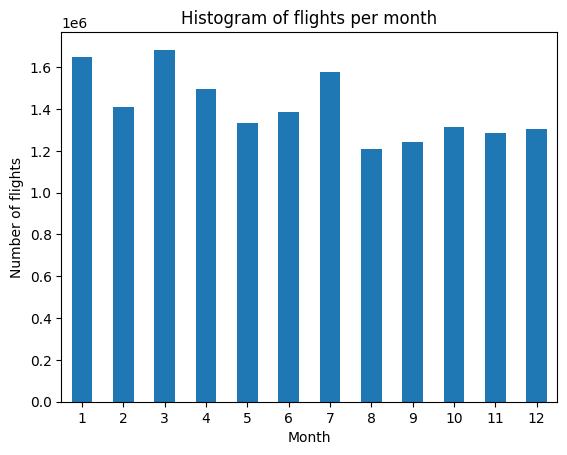

In [18]:
# Plot histogram of flights per month
plt.ylabel("Number of flights")
plt.title("Histogram of flights per month")
flights["Month"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

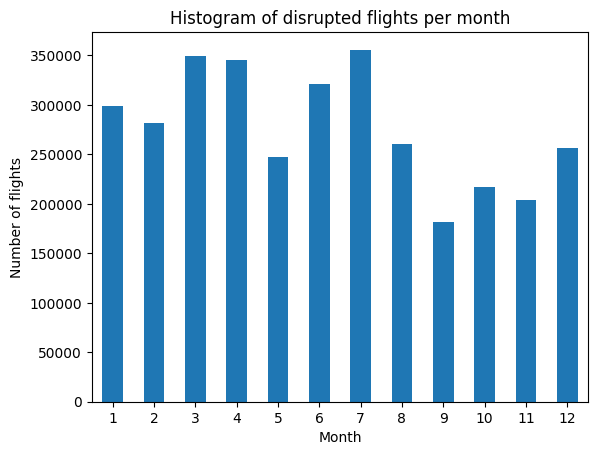

In [19]:
# Plot the number of disrupted flights per month
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights per month")
flights[flights["Disruption"] == 1]["Month"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=0)

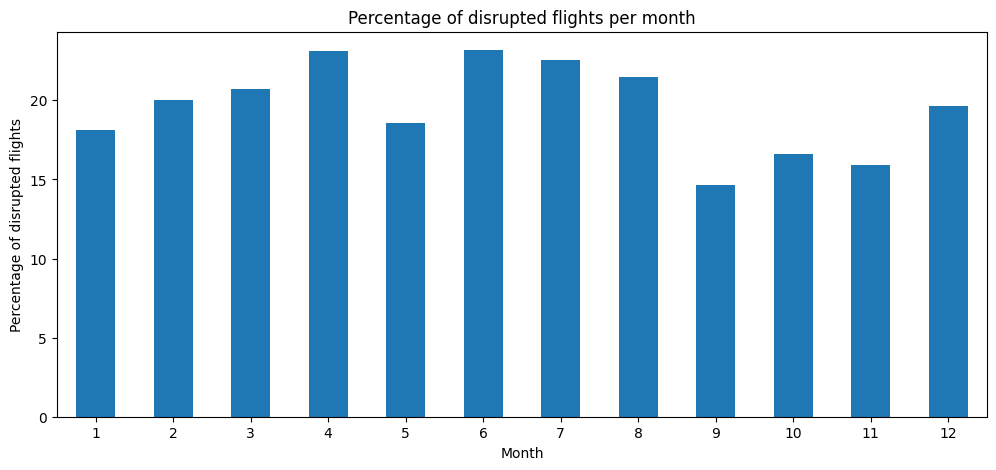

In [20]:
# Plot the percentage of disrupted flights per month
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights per month")
(flights[flights["Disruption"] == 1]["Month"].value_counts().sort_index() / flights["Month"].value_counts().sort_index() * 100).plot(kind="bar")
plt.xticks(rotation=0)
plt.gcf().set_size_inches(12, 5)

Month Observations:
- In general flights appear to be evenly distributed across all the months
- The months of September, October, and November have a visual difference in the proportion of flights that are not cancelled
- June and July have relatively higher cancellation rates

## Explore effect of day of week on disruption

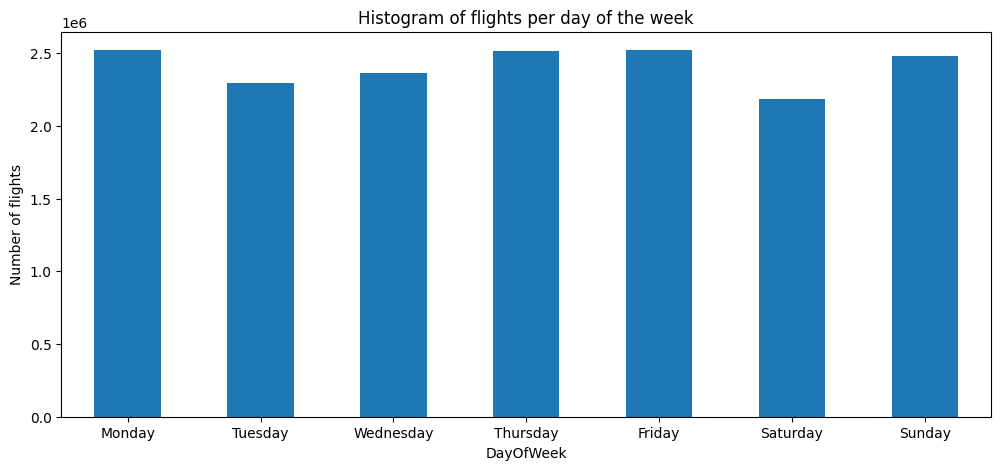

In [21]:
# Plot the number of disrupted flights per day of the week
plt.ylabel("Number of flights")
plt.title("Histogram of flights per day of the week")
flights["DayOfWeek"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xticks(rotation=0)
plt.gcf().set_size_inches(12, 5)

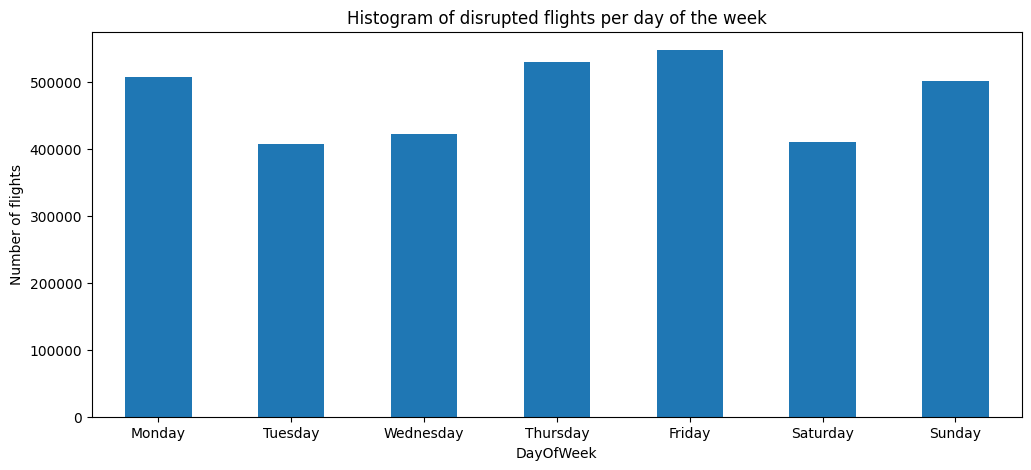

In [22]:
# Plot the number of disrupted flights per day of the week
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights per day of the week")
flights[flights["Disruption"] == 1]["DayOfWeek"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xticks(rotation=0)
plt.gcf().set_size_inches(12, 5)

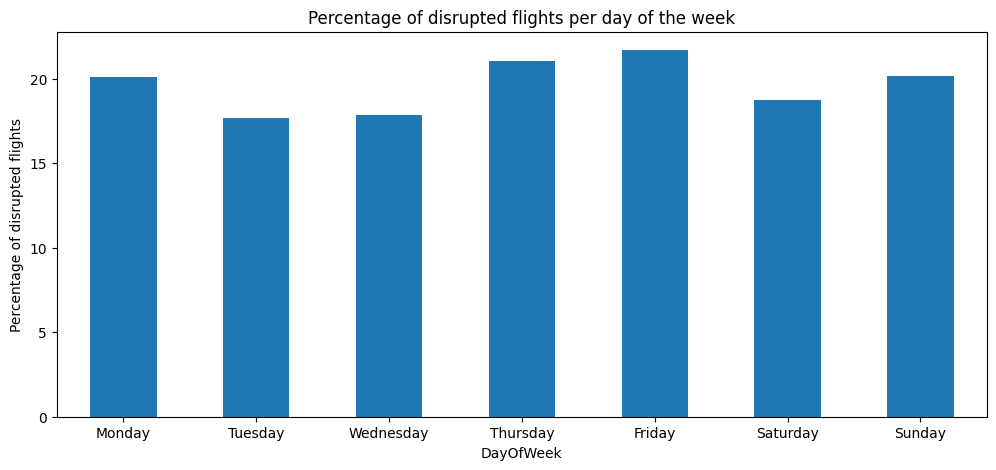

In [23]:
# Plot the percentage of disrupted flights per day of the week
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights per day of the week")
(flights[flights["Disruption"] == 1]["DayOfWeek"].value_counts().sort_index() / flights["DayOfWeek"].value_counts().sort_index() * 100).plot(kind="bar")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xticks(rotation=0)
plt.gcf().set_size_inches(12, 5)

- Observations on day of the week:
    - There appear to be more disruptions on Thursday and Friday proportionally but it may not appear to be so significant between the day of the week a flight takes off and the percentage of disruption
        - Probably will not use this attribute to train the model

## Explore the effect of departure block on disruption

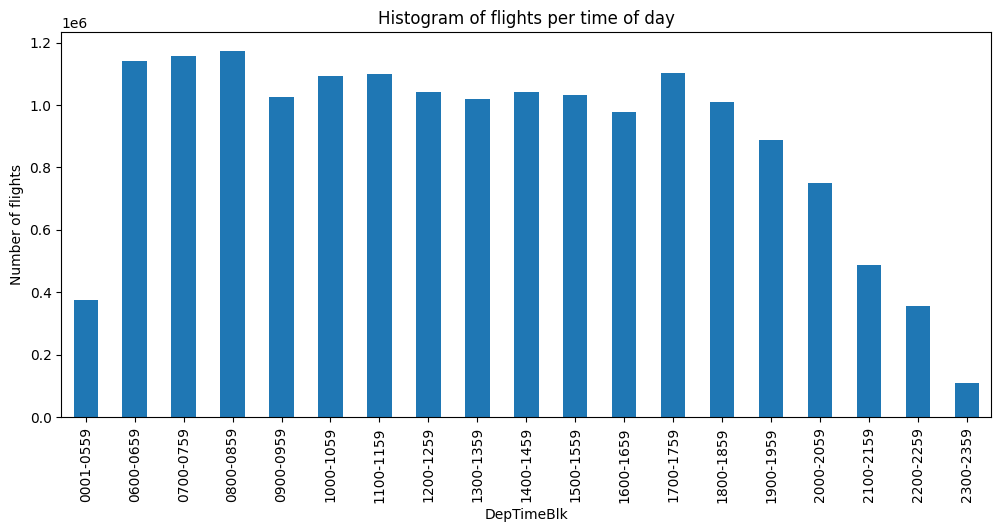

In [24]:
# Plot histogram of flights per time of day
plt.ylabel("Number of flights")
plt.title("Histogram of flights per time of day")
flights["DepTimeBlk"].value_counts().sort_index().plot(kind="bar")
plt.gcf().set_size_inches(12, 5)

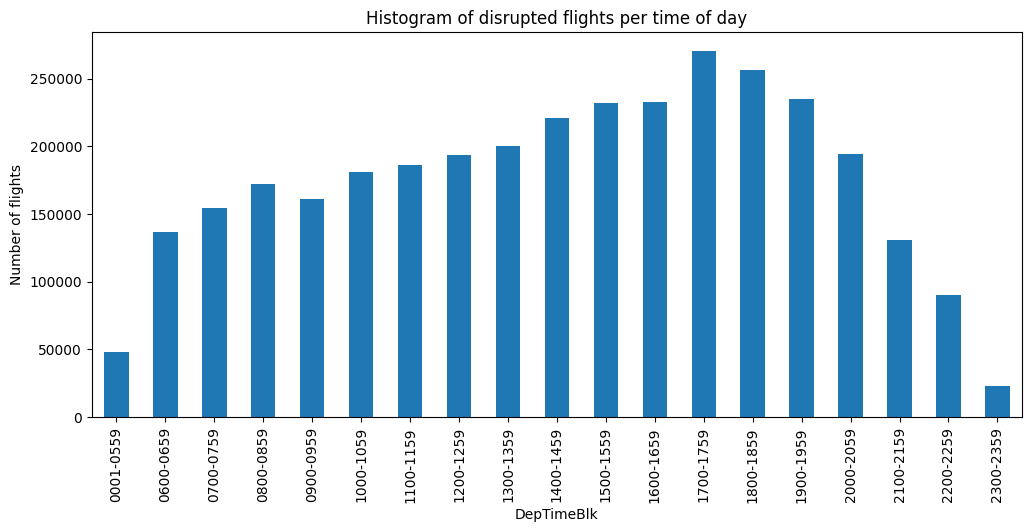

In [25]:
# Plot histogram of disrupted flights per time of day
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights per time of day")
flights[flights["Disruption"] == 1]["DepTimeBlk"].value_counts().sort_index().plot(kind="bar")
plt.gcf().set_size_inches(12, 5)

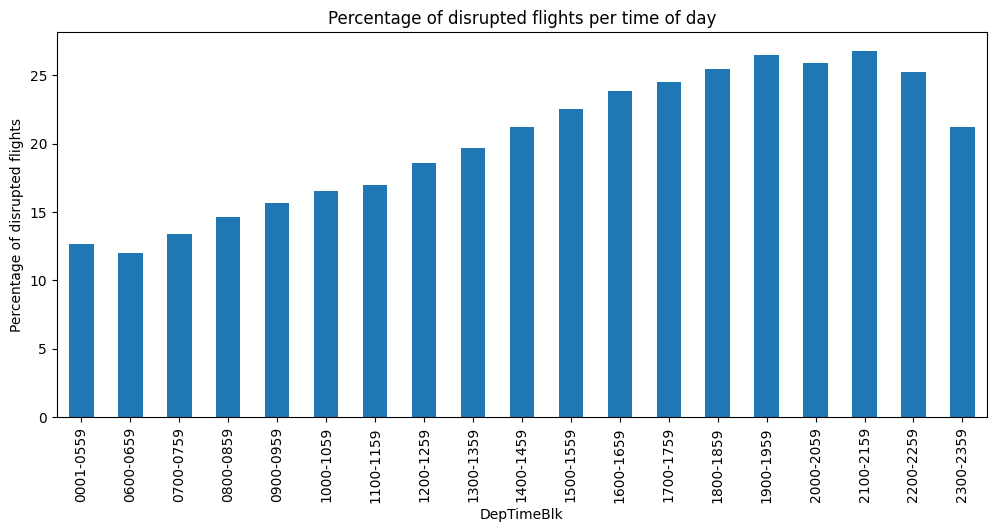

In [26]:
# Plot histogram of percentage disrupted flights per time of day
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights per time of day")
(flights[flights["Disruption"] == 1]["DepTimeBlk"].value_counts().sort_index() / 
    flights["DepTimeBlk"].value_counts().sort_index() * 100).plot(kind="bar")
plt.gcf().set_size_inches(12, 5)

- Observations on time of day:
    - There are significantly less flights before and after working hours
    - The number of flights peaks at the 7pm block, this could be due to a rush of trying to get flights out at the end of a working day
    - There is a steady increase in the number of disruptions from the start of the day up til the peak. (Left skewed histogram)
        - After the 7pm block, the number and percentage of disruption decreases

## Explore the effect of expected arrival time block on disruption

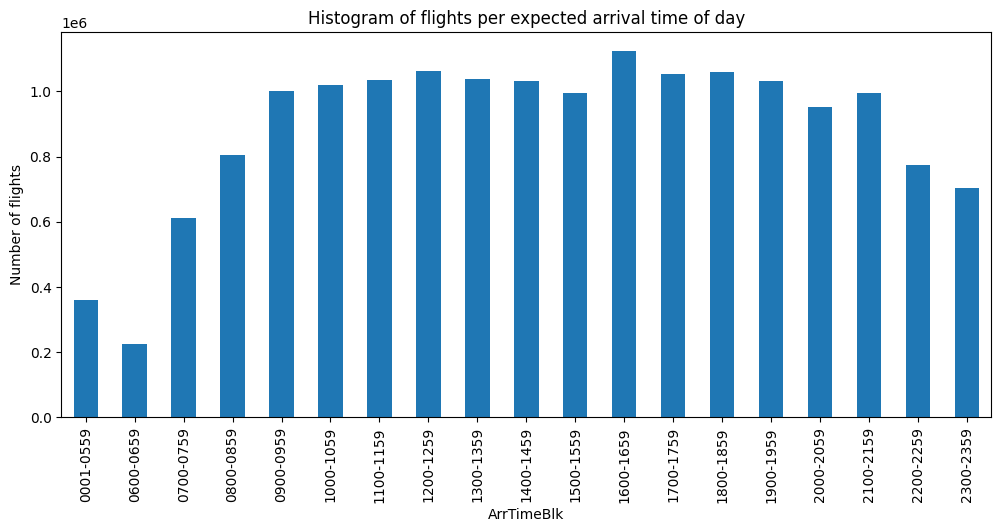

In [27]:
plt.ylabel("Number of flights")
plt.title("Histogram of flights per expected arrival time of day")
flights["ArrTimeBlk"].value_counts().sort_index().plot(kind="bar")
plt.gcf().set_size_inches(12, 5)

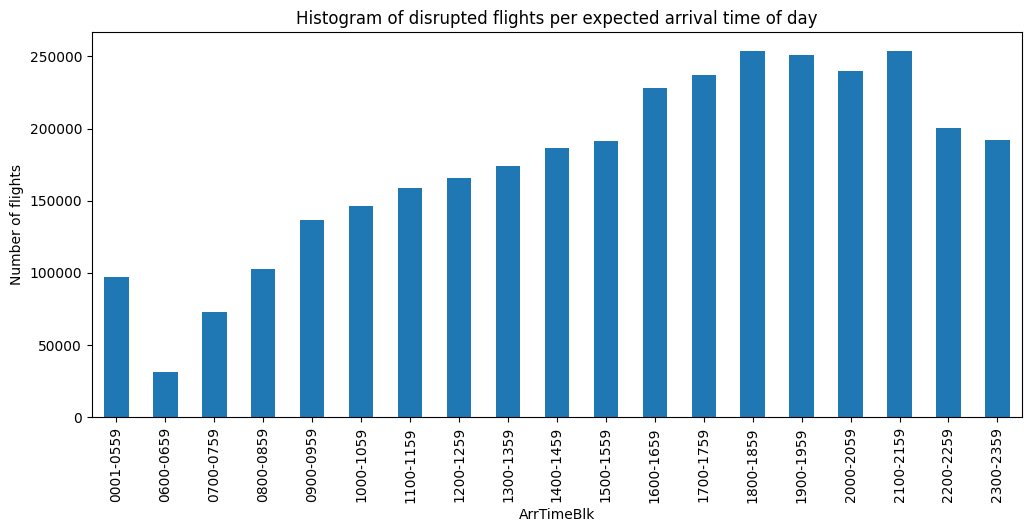

In [28]:
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights per expected arrival time of day")
flights[flights["Disruption"] == 1]["ArrTimeBlk"].value_counts().sort_index().plot(kind="bar")
plt.gcf().set_size_inches(12, 5)

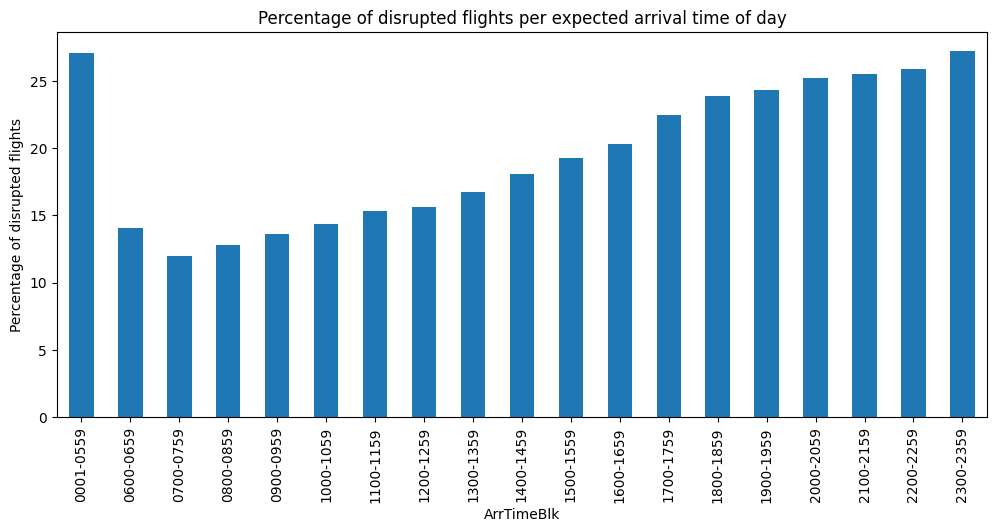

In [29]:
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights per expected arrival time of day")
(flights[flights["Disruption"] == 1]["ArrTimeBlk"].value_counts().sort_index() 
    / flights["ArrTimeBlk"].value_counts().sort_index() * 100).plot(kind="bar")
plt.gcf().set_size_inches(12, 5)


- Observations on expected arrival time block of day on disruptions:
    - There are less flights expected to land at the earlist hours of the day
        - Probably due to the correlation between how little flights take off at the end of the day
    - Follows a similar disruption trend to the departure time block of day where there is a steady increase in the number of disrupted flights up til the 21:00 time block
        - The percentage of disrupted flights however continues to linearly increase from 6:00 to 23:00.
            - The time block 00:01-05:59 time block should probably be thought of as a continuation after 23:00-23:59 if it were to be used as a feature

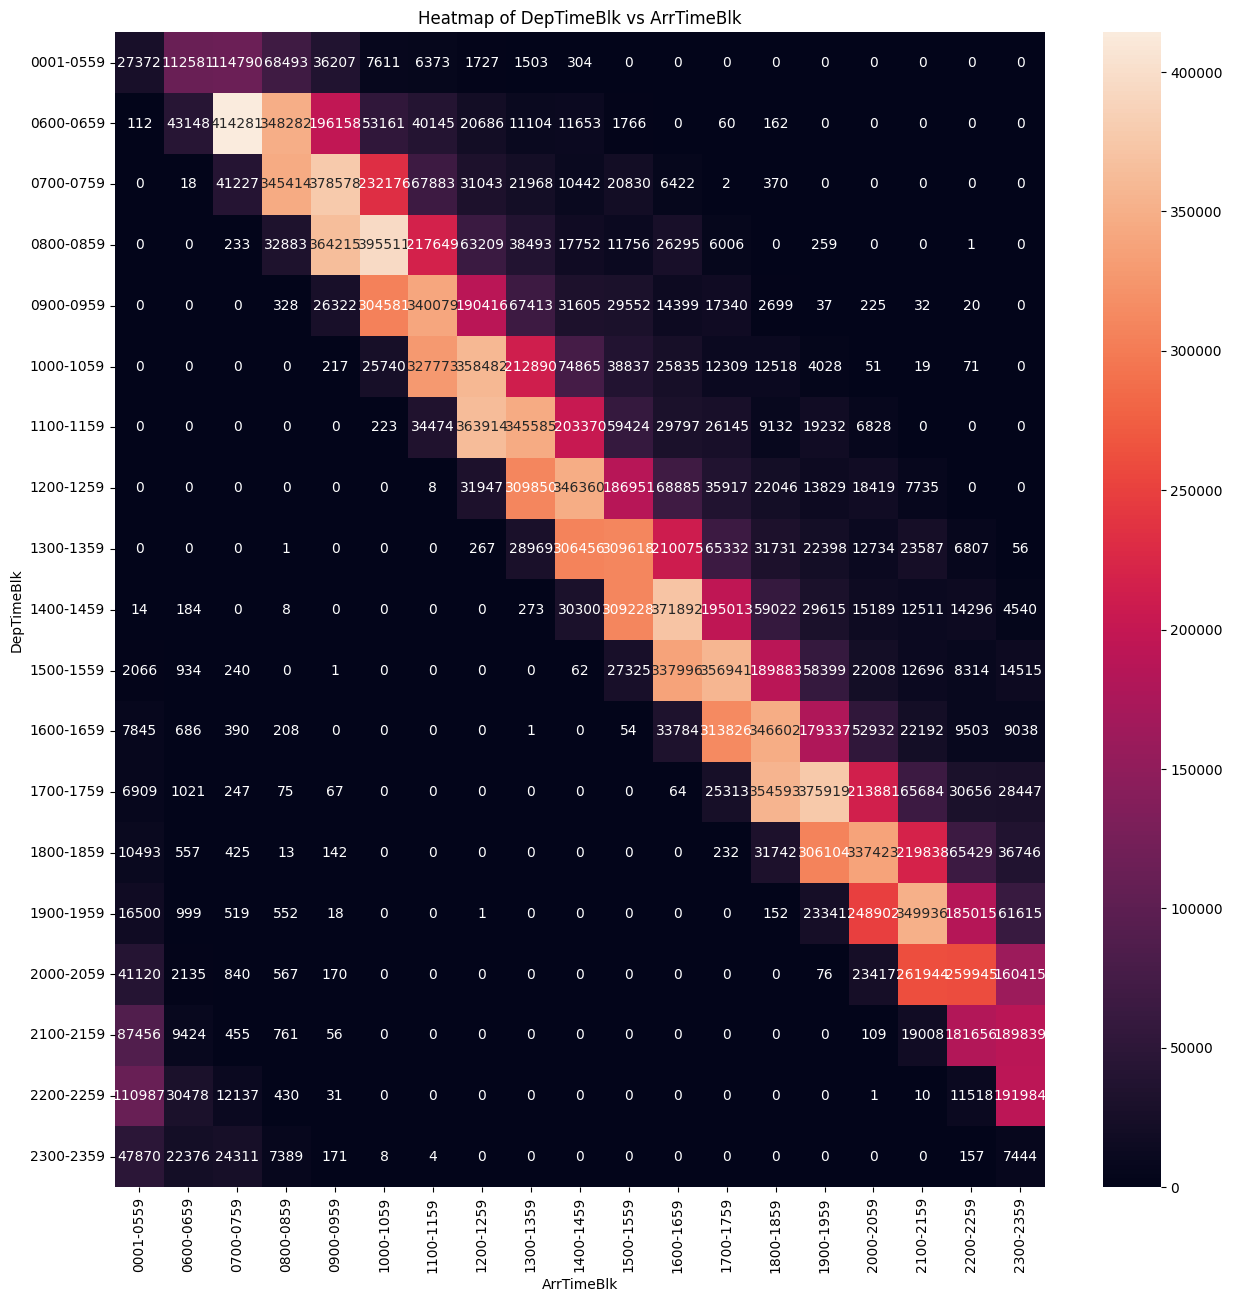

In [30]:
contingency_table = pandas.crosstab(flights["DepTimeBlk"], flights["ArrTimeBlk"])

sns.heatmap(contingency_table, annot=True, fmt="d")

plt.title('Heatmap of DepTimeBlk vs ArrTimeBlk')
plt.xlabel('ArrTimeBlk')
plt.ylabel('DepTimeBlk')
plt.gcf().set_size_inches(15, 15)
plt.show()

- The heatmap above shows that the departure time block and expected arrival time block are highly correlated linearly, probably due to the contraint that the number of flights are domestic within US and its territories, meaning long haul flights are limited and more shorter flights are more common
    - Therefore probably good to only use one of these attributes to train the model

## Explore the effect of Airline on Disruption

In [31]:
print(f'Unique operating airlines: {flights["Operating_Airline"].nunique()}')


Unique operating airlines: 28


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, 'WN'),
  Text(1, 0, 'OO'),
  Text(2, 0, 'DL'),
  Text(3, 0, 'AA'),
  Text(4, 0, 'UA'),
  Text(5, 0, 'YX'),
  Text(6, 0, 'B6'),
  Text(7, 0, 'MQ'),
  Text(8, 0, '9E'),
  Text(9, 0, 'OH'),
  Text(10, 0, 'AS'),
  Text(11, 0, 'NK'),
  Text(12, 0, 'YV'),
  Text(13, 0, 'F9'),
  Text(14, 0, 'G4'),
  Text(15, 0, 'QX'),
  Text(16, 0, 'ZW'),
  Text(17, 0, 'PT'),
  Text(18, 0, 'HA'),
  Text(19, 0, 'EV'),
  Text(20, 0, 'C5'),
  Text(21, 0, 'G7'),
  Text(22, 0, 'AX'),
  Text(23, 0, 'CP'),
  Text(24, 0, 'VX'),
  Text(25, 0, 'EM'),
  Text(26, 0, '9K'),
  Text(27, 0, 'KS')])

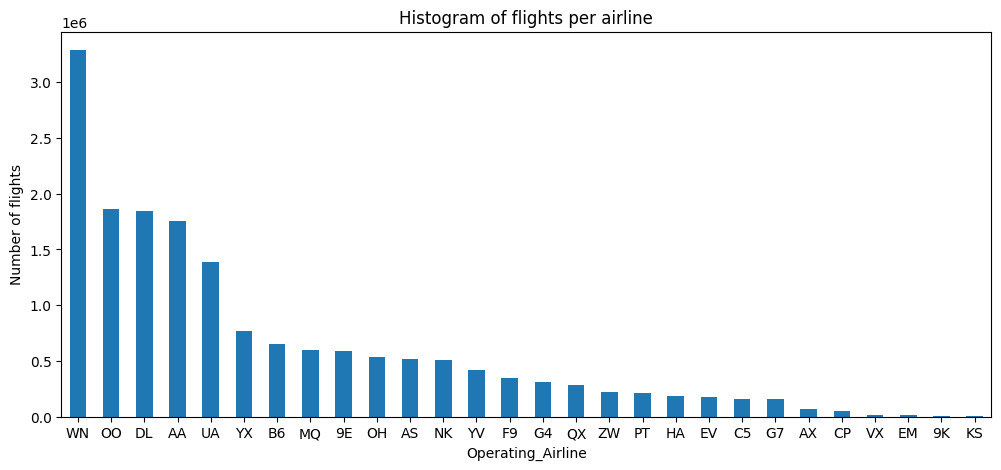

In [32]:
plt.ylabel("Number of flights")
plt.title("Histogram of flights per airline")
flights["Operating_Airline"].value_counts().plot(kind="bar")
plt.gcf().set_size_inches(12, 5)
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, 'WN'),
  Text(1, 0, 'AA'),
  Text(2, 0, 'OO'),
  Text(3, 0, 'UA'),
  Text(4, 0, 'DL'),
  Text(5, 0, 'B6'),
  Text(6, 0, 'YX'),
  Text(7, 0, 'MQ'),
  Text(8, 0, 'NK'),
  Text(9, 0, 'OH'),
  Text(10, 0, 'AS'),
  Text(11, 0, 'G4'),
  Text(12, 0, 'F9'),
  Text(13, 0, 'YV'),
  Text(14, 0, '9E'),
  Text(15, 0, 'ZW'),
  Text(16, 0, 'C5'),
  Text(17, 0, 'QX'),
  Text(18, 0, 'PT'),
  Text(19, 0, 'EV'),
  Text(20, 0, 'G7'),
  Text(21, 0, 'HA'),
  Text(22, 0, 'AX'),
  Text(23, 0, 'CP'),
  Text(24, 0, 'VX'),
  Text(25, 0, 'EM'),
  Text(26, 0, 'KS'),
  Text(27, 0, '9K')])

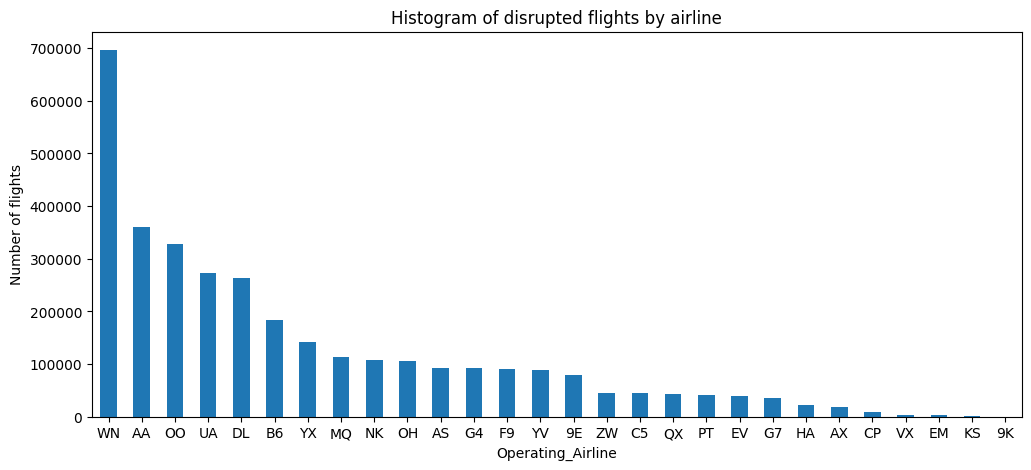

In [33]:
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights by airline")
flights[flights["Disruption"] == 1]["Operating_Airline"].value_counts().plot(kind="bar")
plt.gcf().set_size_inches(12, 5)
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, 'KS'),
  Text(1, 0, 'G4'),
  Text(2, 0, 'B6'),
  Text(3, 0, 'C5'),
  Text(4, 0, 'AX'),
  Text(5, 0, 'F9'),
  Text(6, 0, 'EM'),
  Text(7, 0, 'G7'),
  Text(8, 0, 'EV'),
  Text(9, 0, 'VX'),
  Text(10, 0, 'YV'),
  Text(11, 0, 'WN'),
  Text(12, 0, 'NK'),
  Text(13, 0, 'ZW'),
  Text(14, 0, 'AA'),
  Text(15, 0, 'OH'),
  Text(16, 0, 'UA'),
  Text(17, 0, 'CP'),
  Text(18, 0, 'MQ'),
  Text(19, 0, 'PT'),
  Text(20, 0, 'YX'),
  Text(21, 0, 'AS'),
  Text(22, 0, 'OO'),
  Text(23, 0, 'QX'),
  Text(24, 0, 'DL'),
  Text(25, 0, '9E'),
  Text(26, 0, 'HA'),
  Text(27, 0, '9K')])

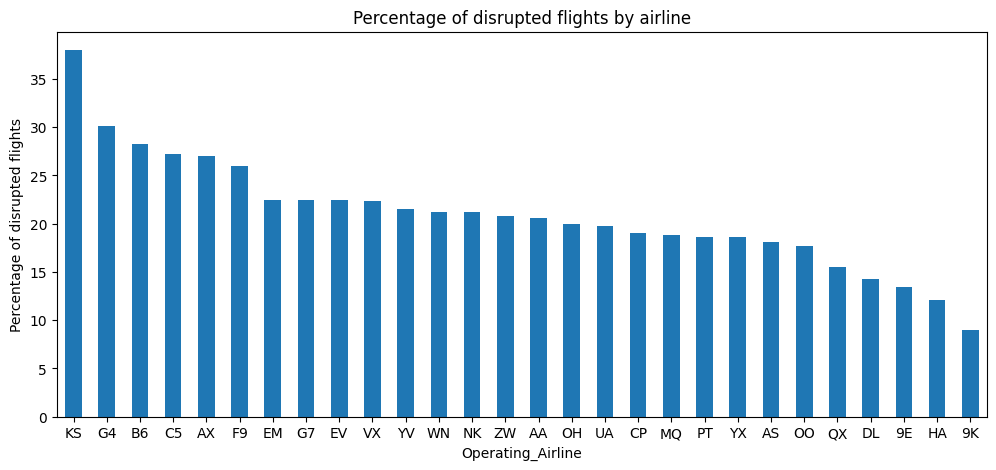

In [34]:
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights by airline")
(flights[flights["Disruption"] == 1]["Operating_Airline"].value_counts() 
    / flights["Operating_Airline"].value_counts() * 100).sort_values(ascending=False).plot(kind="bar")
plt.gcf().set_size_inches(12, 5)
plt.xticks(rotation=0)

In [35]:
print(f'Number of entries for KS: {flights[flights["Operating_Airline"].str.contains("KS")].shape[0]}')

print(f'Percentage of entries for KS: {flights[flights["Operating_Airline"].str.contains("KS")].shape[0] / flights.shape[0] * 100}')

Number of entries for KS: 1045
Percentage of entries for KS: 0.006190306856176543


In [36]:
flights[flights["Operating_Airline"].str.contains("KS")].head(5)

,FlightDate,Airline,Origin,Dest,CRSDepTime,CRSElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrTimeBlk,DistanceGroup,Disruption,Unnamed: 0
19104862,2018-01-02,Peninsula Airways Inc.,ANC,DUT,730,135.0,792,2018,1,1,2,2,AS,AS_CODESHARE,19930,AS,3276,KS,20225,KS,N681PA,3276,10299,1029906,30299,"Anchorage, AK",AK,2,Alaska,1,11445,1144505,31445,"Unalaska, AK",AK,2,Alaska,1,0700-0759,945,0900-0959,4,False,NaN
19104863,2018-01-02,Peninsula Airways Inc.,ANC,DUT,800,135.0,792,2018,1,1,2,2,AS,AS_CODESHARE,19930,AS,3280,KS,20225,KS,N682PA,3280,10299,1029906,30299,"Anchorage, AK",AK,2,Alaska,1,11445,1144505,31445,"Unalaska, AK",AK,2,Alaska,1,0800-0859,1015,1000-1059,4,False,NaN
19104864,2018-01-02,Peninsula Airways Inc.,DUT,ANC,1055,150.0,792,2018,1,1,2,2,AS,AS_CODESHARE,19930,AS,3281,KS,20225,KS,N682PA,3281,11445,1144505,31445,"Unalaska, AK",AK,2,Alaska,1,10299,1029906,30299,"Anchorage, AK",AK,2,Alaska,1,1000-1059,1325,1300-1359,4,False,NaN
19104865,2018-01-02,Peninsula Airways Inc.,ANC,DUT,1430,135.0,792,2018,1,1,2,2,AS,AS_CODESHARE,19930,AS,3284,KS,20225,KS,N681PA,3284,10299,1029906,30299,"Anchorage, AK",AK,2,Alaska,1,11445,1144505,31445,"Unalaska, AK",AK,2,Alaska,1,1400-1459,1645,1600-1659,4,False,NaN
19104866,2018-01-02,Peninsula Airways Inc.,DUT,ANC,1725,150.0,792,2018,1,1,2,2,AS,AS_CODESHARE,19930,AS,3285,KS,20225,KS,N681PA,3285,11445,1144505,31445,"Unalaska, AK",AK,2,Alaska,1,10299,1029906,30299,"Anchorage, AK",AK,2,Alaska,1,1700-1759,1955,1900-1959,4,False,NaN


- Despite operating airlines like Peninsula Airways Inc. having a high percentage of distrubted flights, there are so few entries in proportion to the dataset that it may not be representitive of predictions
    1. It may therefore more useful to look at the top airlines with disrupted flights that have significant numbers of entries in the dataset
    2. On the other hand, it may be good for predicting future flights as if the model has only seen an airline a few times, it may be good to hypothesize that there is a higher chance that this flight would get cancelled

### Exploring how the number of entries an airline has correlate with disruption

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'KS'),
  Text(1, 0, 'G4'),
  Text(2, 0, 'B6'),
  Text(3, 0, 'C5'),
  Text(4, 0, 'AX'),
  Text(5, 0, 'F9'),
  Text(6, 0, 'EM'),
  Text(7, 0, 'G7'),
  Text(8, 0, 'EV'),
  Text(9, 0, 'VX'),
  Text(10, 0, 'YV'),
  Text(11, 0, 'WN'),
  Text(12, 0, 'NK'),
  Text(13, 0, 'ZW'),
  Text(14, 0, 'AA'),
  Text(15, 0, 'OH'),
  Text(16, 0, 'UA'),
  Text(17, 0, 'CP'),
  Text(18, 0, 'MQ'),
  Text(19, 0, 'PT')])

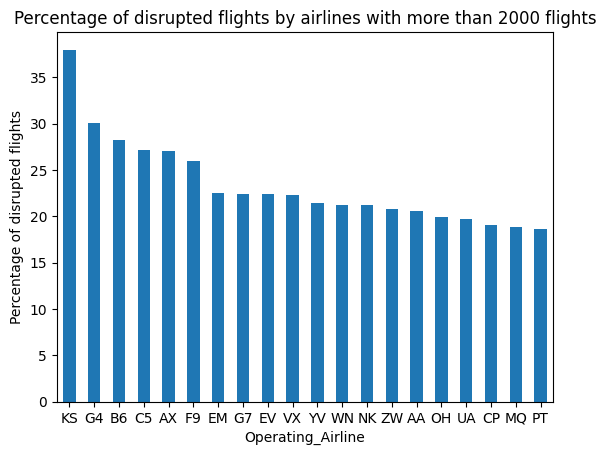

In [37]:
# Plot the histogram of top 5 airlines by percentage of disrupted flights (excluding airlines with less than 2000 flights)
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights by airlines with more than 2000 flights")
flights["Operating_Airline"].value_counts().loc[lambda x: x > 2000].index
(flights[flights["Disruption"] == 1]["Operating_Airline"].value_counts() / flights["Operating_Airline"].value_counts() * 100).sort_values(ascending=False).loc[lambda x: flights["Operating_Airline"].value_counts() > 1000].head(20).plot(kind="bar")
plt.xticks(rotation=0)


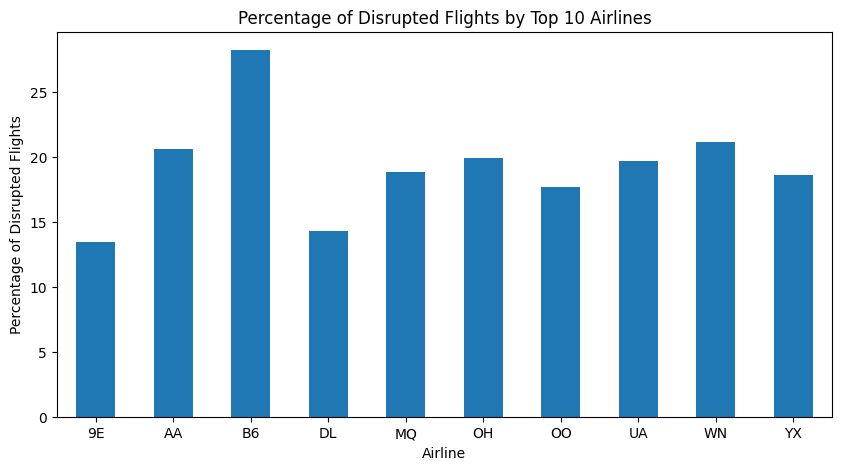

In [38]:
# Plot the percentage of disrupted flights by airline using the same axis as the previous plot
flights[flights["Disruption"] == 1]["Operating_Airline"].value_counts().head(10)

top_10_airlines = flights["Operating_Airline"].value_counts().head(10).index.tolist()

top_10_flights = flights[flights["Operating_Airline"].isin(top_10_airlines)]
top_10_flights_disruption_percentage = (top_10_flights.groupby("Operating_Airline")["Disruption"].mean() * 100)

plt.figure(figsize=(10, 5))
top_10_flights_disruption_percentage.plot(kind='bar')
plt.title('Percentage of Disrupted Flights by Top 10 Airlines')
plt.xlabel('Airline')
plt.ylabel('Percentage of Disrupted Flights')
plt.xticks(rotation=0)
plt.show()


In [39]:
# Find the min, max, mean, median and standard deviation of the each airline's percentage of disrupted flights
print("Min, max, mean, median and standard deviation of the each airline's percentage of disrupted flights")

disruption_percentage = (flights.groupby("Operating_Airline")["Disruption"].mean() * 100)

print(disruption_percentage.agg(['min', 'max', 'mean', 'median', 'std']))

Q1 = disruption_percentage.quantile(0.25)
Q3 = disruption_percentage.quantile(0.75)

print(f'\nQ1: {Q1}, Q3: {Q3}')

Min, max, mean, median and standard deviation of the each airline's percentage of disrupted flights
min        9.014515
max       37.990431
mean      20.941622
median    20.718259
std        5.865449
Name: Disruption, dtype: float64

Q1: 18.464016846451006, Q3: 22.460944450872297


In [40]:
number_of_entries_per_airline = flights["Operating_Airline"].value_counts()

percentage_of_entries_per_airline = (flights["Operating_Airline"].value_counts() / len(flights) * 100)

# percentage of disrupted flights per airline
disruption_percentage_per_airline = (flights.groupby("Operating_Airline")["Disruption"].mean() * 100)

data = {
    'Number_of_entries': number_of_entries_per_airline,
    'Percentage_of_entries': percentage_of_entries_per_airline,
    'Percent_of_disrupted_flights': disruption_percentage_per_airline
}
df = pandas.DataFrame(data)

# Reset the index of the DataFrame to make the 'Operating_Airline' column accessible
df.reset_index(inplace=True)

# Rename the 'index' column to 'Operating_Airline'
df.rename(columns={'index': 'Operating_Airline'}, inplace=True)

print(df)

   Operating_Airline  Number_of_entries  Percentage_of_entries  \
0                 9E             591839               3.505900   
1                 9K               1309               0.007754   
2                 AA            1749456              10.363320   
3                 AS             513129               3.039642   
4                 AX              68413               0.405261   
5                 B6             646982               3.832552   
6                 C5             162034               0.959847   
7                 CP              48700               0.288486   
8                 DL            1842390              10.913837   
9                 EM              11445               0.067797   
10                EV             175368               1.038834   
11                F9             347506               2.058535   
12                G4             307358               1.820708   
13                G7             158167               0.936940   
14        

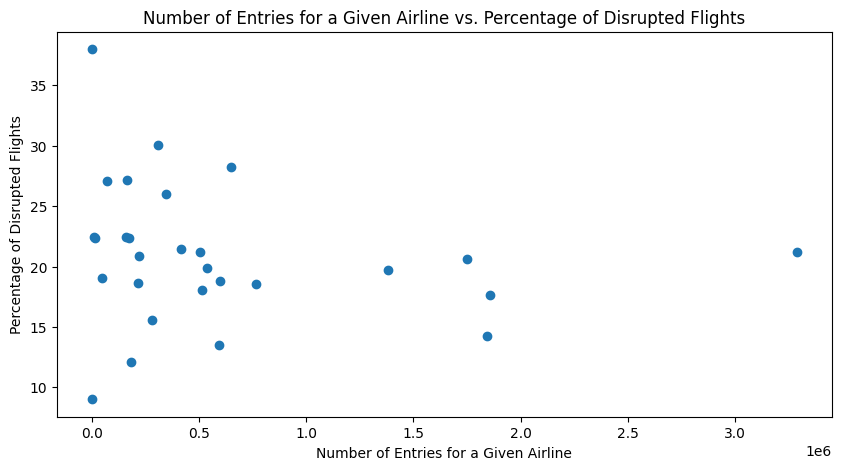

In [41]:
plt.figure(figsize=(10, 5))
plt.scatter(df["Number_of_entries"], df["Percent_of_disrupted_flights"])
plt.title('Number of Entries for a Given Airline vs. Percentage of Disrupted Flights')
plt.xlabel('Number of Entries for a Given Airline')
plt.ylabel('Percentage of Disrupted Flights')
plt.show()

- On average, you can expect to have a disrupted flight around 21% of the time
    - If an airline has few entries in the dataset, it has a higher variation in terms of the chance of disruption as seen by the main cluster
        - These airlines with few entries also experience distruptions of 25%+, which is not common for airlines with more entries
            - This transformation to represent a given airline as some form of number proportional to its entry may therefore be useful (any unseen entries predict can be automatically set to 0)

## Explore the effect of distance on Disruption

In [42]:
print(f'Maximum distance: {flights["Distance"].max()}')
print(f'Minimum distance: {flights["Distance"].min()}')
print(f'Average distance: {flights["Distance"].mean()}')
print(f'Standard deviation: {flights["Distance"].std()}')

Maximum distance: 5812
Minimum distance: 16
Average distance: 784.2757272262905


Standard deviation: 580.5845649868965


<Axes: title={'center': 'Boxplot of distance'}, ylabel='Distance'>

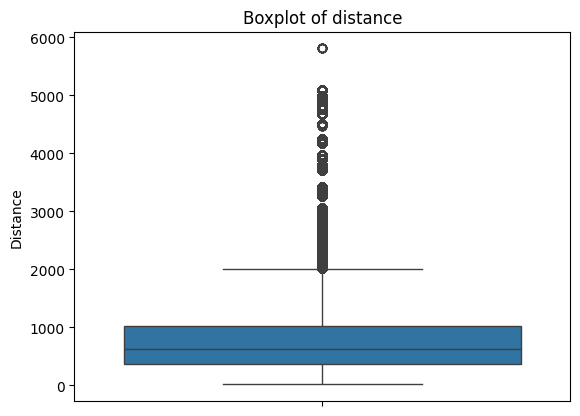

In [43]:
plt.ylabel("Distance")
plt.title("Boxplot of distance")
sns.boxplot(data=flights, y="Distance")

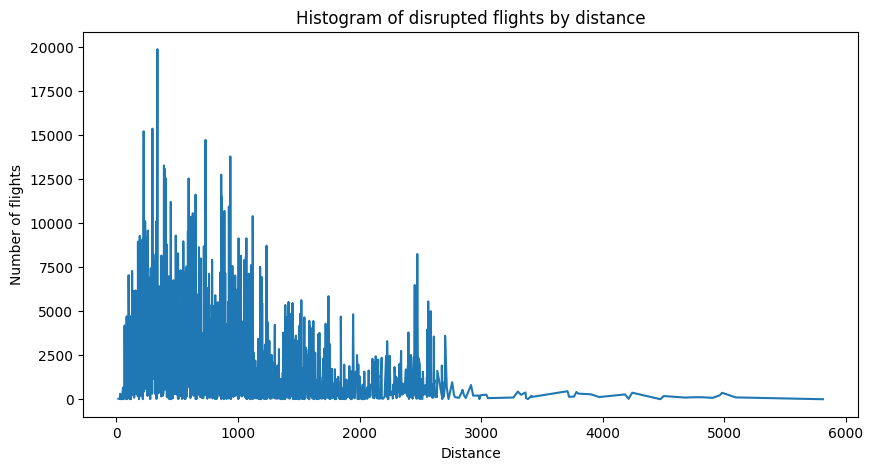

In [44]:
plt.ylabel("Number of flights")
plt.title("Histogram of disrupted flights by distance")
flights[flights["Disruption"] == 1]["Distance"].value_counts().sort_index().plot()
plt.gcf().set_size_inches(10, 5)

In [45]:
print(f'Number of flights with distance greater than 2500: {len(flights[flights["Distance"] > 2500])}')
print(f'Number of flights with distance greater than 2525: {len(flights[flights["Distance"] > 2625])}')
print(f'Number of flights with distance greater than 2500: {len(flights[flights["Distance"] > 2750])}')
print(f'Number of flights with distance greater than 3000: {len(flights[flights["Distance"] > 3000])}')
print(f'Number of flights with distance greater than 3500: {len(flights[flights["Distance"] > 3500])}')

Number of flights with distance greater than 2500: 291297
Number of flights with distance greater than 2525: 110863
Number of flights with distance greater than 2500: 55384
Number of flights with distance greater than 3000: 31400
Number of flights with distance greater than 3500: 21515


In [46]:
print(f'Percentage of flights with distance greater than 2500: {len(flights[flights["Distance"] > 2500]) / len(flights) * 100}')
print(f'Percentage of flights with distance greater than 2625: {len(flights[flights["Distance"] > 2625]) / len(flights) * 100}')
print(f'Percentage of flights with distance greater than 2750: {len(flights[flights["Distance"] > 2750]) / len(flights) * 100}')
print(f'Percentage of flights with distance greater than 3000: {len(flights[flights["Distance"] > 3000]) / len(flights) * 100}')

Percentage of flights with distance greater than 2500: 1.725567288309721
Percentage of flights with distance greater than 2625: 0.6567234344462202
Percentage of flights with distance greater than 2750: 0.32808033963873845
Percentage of flights with distance greater than 3000: 0.18600539261621382


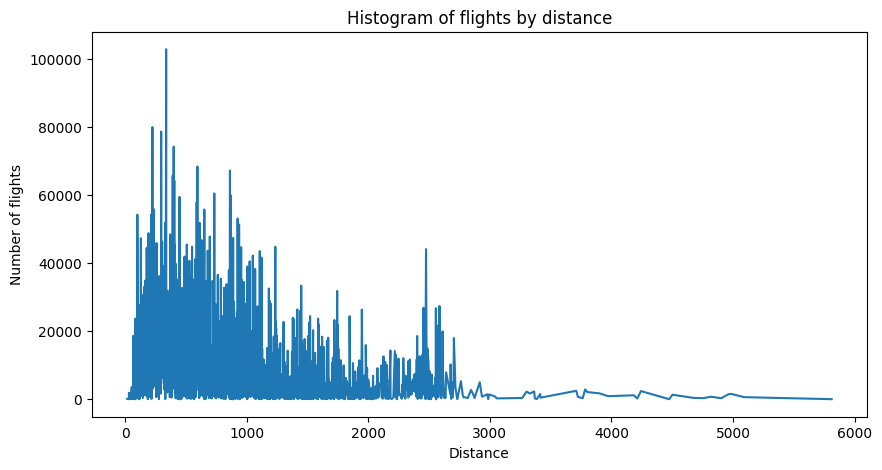

In [47]:
plt.ylabel("Number of flights")
plt.title("Histogram of flights by distance")
flights["Distance"].value_counts().sort_index().plot()
plt.gcf().set_size_inches(10, 5)

In [48]:
df = flights[flights["Distance"] > 2750]

disrupted_flights = len(df[df["Disruption"] == 1]["Distance"])

num_flights_over_2750 = len(df)

percentage_disrupted_flights = disrupted_flights / num_flights_over_2750 * 100


print("Percentage of disrupted flights given flights are over 2625 miles ", percentage_disrupted_flights)

Percentage of disrupted flights given flights are over 2625 miles  18.025061389570997


- Overvations on Distance:
    - Non-linear M shaped pattern where the number of disruptions for shorter flights are more common with a smaller spike at around 2,5000 miles 
    - Outliers of long distance flights present in the dataset, these flights are disrupted lower than average
        - As a transformation, it may be useful to cap all flights that fly more than 2,750 miles to 2,750 miles so that when the data is normalised, these large values do not skew the process

## Explore the effect of origin & destination airport on Disruption

Given that I can only choose up to 10 features, I decided to choose both origin and destination airport on disruption as my 8th and 9th attribute as opposed to origin and destination state. This is because similar to month attribute, exploring the affect of origin state may not capture the full picture in comparison to the airport itself. The trade-off is that there might be a more widespread patterns that I may be missing out

In [49]:
print(f'Number of airports: {len(flights["OriginAirportID"].unique())}')

Number of airports: 388


Look at the airports with the most entries first to see if any pattern emerges:

In [50]:
top_10_origin_airports = flights["OriginAirportID"].value_counts().head(10)

print(f'Top 10 origin airports: {sorted(flights[flights["OriginAirportID"].isin(top_10_origin_airports.index)]["Origin"].unique())}')

top_10_dest_airports = flights["DestAirportID"].value_counts().head(10)

print(f'Top 10 destination airports: {sorted(flights[flights["DestAirportID"].isin(top_10_dest_airports.index)]["Dest"].unique())}')

# find intersection of top 10 origin and destination airports
intersection = top_10_origin_airports.index.intersection(top_10_dest_airports.index)

print(f'Top 10 origin and destination airports intersection: {sorted(flights[flights["OriginAirportID"].isin(intersection)]["Origin"].unique())}')

Top 10 origin airports: ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAS', 'LAX', 'ORD', 'PHX', 'SEA']
Top 10 destination airports: ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAS', 'LAX', 'ORD', 'PHX', 'SEA']
Top 10 origin and destination airports intersection: ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAS', 'LAX', 'ORD', 'PHX', 'SEA']


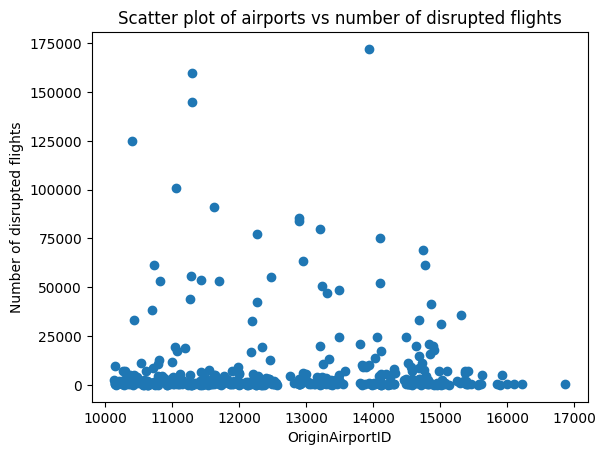

In [51]:
# Filter flights for disrupted flights
disrupted_flights = flights[flights["Disruption"] == 1]

# Count the number of disrupted flights for each airport
disrupted_flights_per_airport = disrupted_flights["OriginAirportID"].value_counts()

# Create scatter plot
plt.scatter(disrupted_flights_per_airport.index, disrupted_flights_per_airport.values)
plt.xlabel("OriginAirportID")
plt.ylabel("Number of disrupted flights")
plt.title("Scatter plot of airports vs number of disrupted flights")
plt.show()

Did not expect any trend given that there is no inhert order to the airport ID

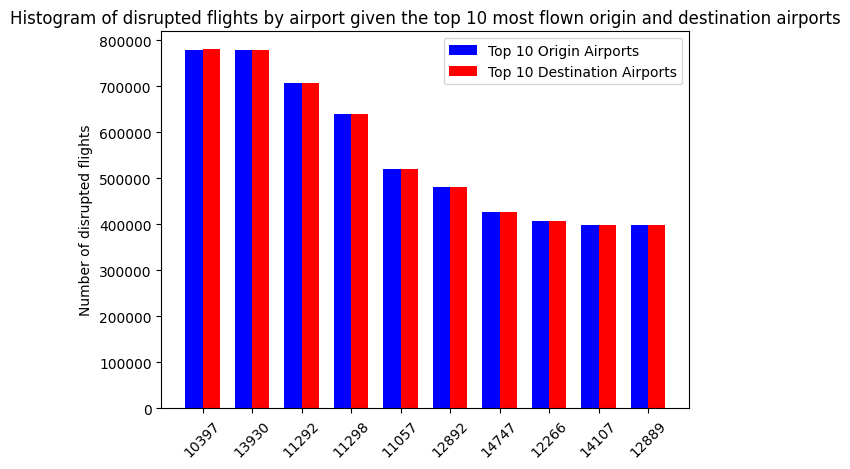

In [52]:
df = pandas.DataFrame({'Origin': top_10_origin_airports, 'Destination': top_10_dest_airports})

df = df.fillna(0)

top_airpots = top_10_origin_airports + top_10_dest_airports

x = np.arange(len(top_airpots))

bar_width = 0.35

# Plot the histogram for origin airports
plt.bar(x - bar_width/2, df['Origin'], bar_width, color='b', label='Top 10 Origin Airports')

# Plot the histogram for destination airports
plt.bar(x + bar_width/2, df['Destination'], bar_width, color='r', label='Top 10 Destination Airports')

# Set labels and title
plt.ylabel("Number of disrupted flights")
plt.title("Histogram of disrupted flights by airport given the top 10 most flown origin and destination airports")
plt.xticks(x, df.index, rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

Plotting the airports with the highest proportion of disrupted flights:

Text(0, 0.5, 'Percentage of disrupted flights')

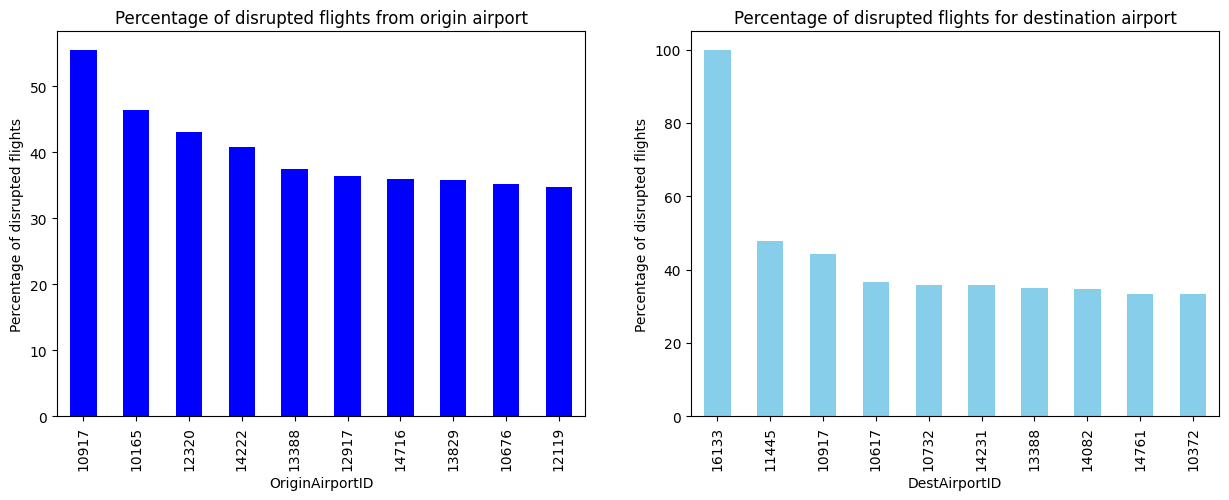

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

(flights[flights["Disruption"] == 1]["OriginAirportID"].value_counts() / 
    flights["OriginAirportID"].value_counts() * 100).sort_values(ascending=False).head(10).plot(kind="bar", ax=axs[0],color ='b')
axs[0].set_title('Percentage of disrupted flights from origin airport')
axs[0].set_ylabel('Percentage of disrupted flights')

(flights[flights["Disruption"] == 1]["DestAirportID"].value_counts() / 
    flights["DestAirportID"].value_counts() * 100).sort_values(ascending=False).head(10).plot(kind="bar", ax=axs[1],color ='skyblue')
axs[1].set_title('Percentage of disrupted flights for destination airport')
axs[1].set_ylabel('Percentage of disrupted flights')

Intersection of airports with the most disrupted flights and airports with the highest percentage of disrupted flights

In [54]:
top_10_disrupted_airports = set(disrupted_flights["OriginAirportID"].value_counts().head(10).index)
top_10_disrupted_airports_percentage = set((flights[flights["Disruption"] == 1]["OriginAirportID"].value_counts() / flights["OriginAirportID"].value_counts() * 100).sort_values(ascending=False).head(10).index)
top_10_disrupted_airports.intersection(top_10_disrupted_airports_percentage)

set()

In [55]:
for airport in (flights[flights["Disruption"] == 1]["OriginAirportID"].value_counts() / flights["OriginAirportID"].value_counts() * 100).sort_values(ascending=False).head(10).index:
    print(f'Number of entries for origin airport {airport}: {len(flights[flights["OriginAirportID"] == airport])}')

for airport in (flights[flights["Disruption"] == 1]["DestAirportID"].value_counts() / flights["DestAirportID"].value_counts() * 100).sort_values(ascending=False).head(10).index:
    print(f'Number of entries for destination airport {airport}: {len(flights[flights["DestAirportID"] == airport])}')

Number of entries for origin airport 10917: 225
Number of entries for origin airport 10165: 278
Number of entries for origin airport 12320: 144
Number of entries for origin airport 14222: 142
Number of entries for origin airport 13388: 582
Number of entries for origin airport 12917: 3178
Number of entries for origin airport 14716: 1996
Number of entries for origin airport 13829: 273
Number of entries for origin airport 10676: 3334
Number of entries for origin airport 12119: 512
Number of entries for destination airport 16133: 2
Number of entries for destination airport 11445: 520
Number of entries for destination airport 10917: 206
Number of entries for destination airport 10617: 238
Number of entries for destination airport 10732: 4386
Number of entries for destination airport 14231: 1297
Number of entries for destination airport 13388: 573
Number of entries for destination airport 14082: 16764
Number of entries for destination airport 14761: 27361
Number of entries for destination ai

- As with the previous attributes, the attributes with the lower number of entries within the dataset are expected to be the ones with the highest proportion of disruptions
- As observed with the airports above, this trend is also true

<Axes: title={'center': 'Percentage of disrupted flights by airports with more than 1000 flights'}, xlabel='OriginAirportID', ylabel='Percentage of disrupted flights'>

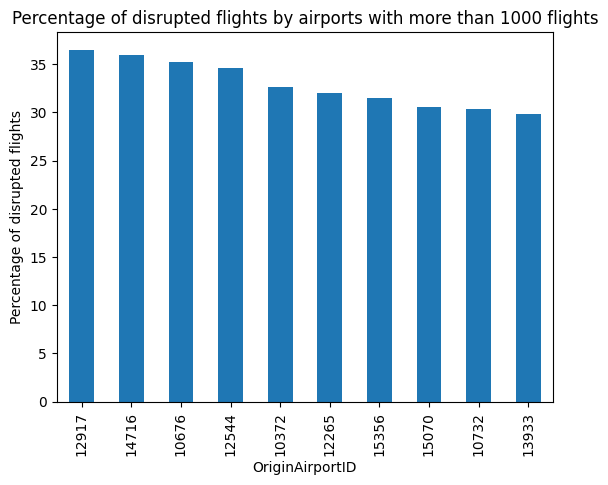

In [56]:
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights by airports with more than 1000 flights")
(flights[flights["Disruption"] == 1]["OriginAirportID"].value_counts() / flights["OriginAirportID"].value_counts() * 100).sort_values(ascending=False).loc[lambda x: flights["OriginAirportID"].value_counts() > 1000].head(10).plot(kind="bar")


Print the number of entries for the airports with the highest percentage of disrupted flights for airports with more than 1000 entries:

In [57]:
airport_ID_value_counts_disrupted = flights[flights["Disruption"] == 1]["OriginAirportID"].value_counts()
airport_ID_value_counts = flights["OriginAirportID"].value_counts()
for airport in (airport_ID_value_counts_disrupted / airport_ID_value_counts * 100).loc[lambda x: airport_ID_value_counts > 1000].head(10).index:
    print(f'Number of entries for airport {airport}: {len(flights[flights["OriginAirportID"] == airport])}')

Number of entries for airport 10135: 12906
Number of entries for airport 10136: 4925
Number of entries for airport 10140: 54410
Number of entries for airport 10141: 1810
Number of entries for airport 10146: 2271
Number of entries for airport 10154: 3747
Number of entries for airport 10155: 3516
Number of entries for airport 10157: 4481
Number of entries for airport 10158: 8270
Number of entries for airport 10170: 1951


In [58]:

top_10_origin_airports_set = set(top_10_origin_airports.index)
top_10_airports_percentage = set((flights[flights["Disruption"] == 1]["OriginAirportID"]
                                  .value_counts() / flights["OriginAirportID"].value_counts() * 100)
                                  .loc[lambda x: flights["OriginAirportID"].value_counts() > 1000]
                                  .head(10).index)
print("Intersection of top 10 airports and top 10 airports by percentage of disrupted flights with more than 1000 entries: ",
       top_10_origin_airports_set.intersection(top_10_airports_percentage))

Intersection of top 10 airports and top 10 airports by percentage of disrupted flights with more than 1000 entries:  set()


In [59]:
print("Min, max, mean, median and standard deviation of the each origin airport's distrupted flights")

disruption_percentage = (flights.groupby("OriginAirportID")["Disruption"].mean() * 100)

print(disruption_percentage.agg(['min', 'max', 'mean', 'median', 'std']))

Q1 = disruption_percentage.quantile(0.25)
Q3 = disruption_percentage.quantile(0.75)

print(f'\nQ1: {Q1}, Q3: {Q3}')

Min, max, mean, median and standard deviation of the each origin airport's distrupted flights
min        0.000000
max       55.555556
mean      19.528461
median    18.430462
std        5.801512
Name: Disruption, dtype: float64

Q1: 16.34019567064833, Q3: 21.16573505688414


In [60]:
print("Min, max, mean, median and standard deviation of the each destination airport's distrupted flights")

disruption_percentage = (flights.groupby("DestAirportID")["Disruption"].mean() * 100)

print(disruption_percentage.agg(['min', 'max', 'mean', 'median', 'std']))

Q1 = disruption_percentage.quantile(0.25)
Q3 = disruption_percentage.quantile(0.75)

print(f'\nQ1: {Q1}, Q3: {Q3}')

Min, max, mean, median and standard deviation of the each destination airport's distrupted flights
min         7.874016
max       100.000000
mean       19.963125
median     19.366962
std         6.317327
Name: Disruption, dtype: float64

Q1: 17.050986652428666, Q3: 21.62309300704716


In [61]:
number_of_entries_per_airport = flights["OriginAirportID"].value_counts()

percentage_of_entries_per_airport = (flights["OriginAirportID"].value_counts() / len(flights) * 100)

# percentage of disrupted flights per airline
disruption_percentage_per_airport = (flights.groupby("OriginAirportID")["Disruption"].mean() * 100)

data = {
    'Number_of_entries': number_of_entries_per_airport,
    'Percentage_of_entries': percentage_of_entries_per_airport,
    'Percent_of_disrupted_flights': disruption_percentage_per_airport
}
df = pandas.DataFrame(data)

# Reset the index of the DataFrame to make the 'Operating_Airline' column accessible
df.reset_index(inplace=True)

# Rename the 'index' column to 'Operating_Airline'
df.rename(columns={'index': 'OriginAirportID'}, inplace=True)

print(df)

     OriginAirportID  Number_of_entries  Percentage_of_entries  \
0              10135              12906               0.076452   
1              10136               4925               0.029174   
2              10140              54410               0.322311   
3              10141               1810               0.010722   
4              10146               2271               0.013453   
..               ...                ...                    ...   
383            15991               1952               0.011563   
384            16101               2345               0.013891   
385            16133                  1               0.000006   
386            16218               3936               0.023316   
387            16869               2314               0.013708   

     Percent_of_disrupted_flights  
0                       19.130637  
1                       20.730964  
2                       18.083073  
3                       13.922652  
4                       12.

In [62]:
number_of_entries_per_dest_airport = flights["DestAirportID"].value_counts()

percentage_of_entries_per_dest_airport = (flights["DestAirportID"].value_counts() / len(flights) * 100)

# percentage of disrupted flights per airline
disruption_percentage_per_dest_airport = (flights.groupby("DestAirportID")["Disruption"].mean() * 100)

data2 = {
    'Number_of_entries': number_of_entries_per_dest_airport,
    'Percentage_of_entries': percentage_of_entries_per_dest_airport,
    'Percent_of_disrupted_flights': disruption_percentage_per_dest_airport
}
df2 = pandas.DataFrame(data2)

# Reset the index of the DataFrame to make the 'Operating_Airline' column accessible
df2.reset_index(inplace=True)

# Rename the 'index' column to 'Operating_Airline'
df2.rename(columns={'index': 'DestAirportID'}, inplace=True)

print(df2)

     DestAirportID  Number_of_entries  Percentage_of_entries  \
0            10135              12998               0.076997   
1            10136               4924               0.029168   
2            10140              54473               0.322684   
3            10141               1814               0.010746   
4            10146               2286               0.013542   
..             ...                ...                    ...   
383          15991               1995               0.011818   
384          16101               2315               0.013713   
385          16133                  2               0.000012   
386          16218               3896               0.023079   
387          16869               2276               0.013482   

     Percent_of_disrupted_flights  
0                       21.449454  
1                       16.104793  
2                       20.795624  
3                       12.844542  
4                       12.510936  
..             

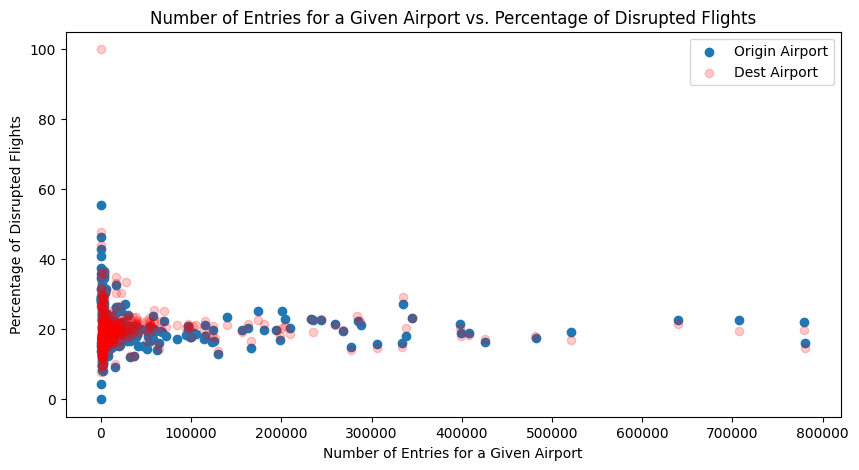

In [63]:
plt.figure(figsize=(10, 5))
plt.scatter(df["Number_of_entries"], df["Percent_of_disrupted_flights"], label='Origin Airport')
plt.scatter(df2["Number_of_entries"], df2["Percent_of_disrupted_flights"], color='red', label='Dest Airport', alpha=0.2)
plt.title('Number of Entries for a Given Airport vs. Percentage of Disrupted Flights')
plt.xlabel('Number of Entries for a Given Airport')
plt.ylabel('Percentage of Disrupted Flights')
plt.legend()
plt.show()

- Observations:
    - It can be observed that there is greater variance for airports with less entries, the number of disrupted flights has a large variance
        - As a transformation, it may be useful to represent the airports using the number of entries to capture this

## Explore the effect of Origin State on Disruption

In [64]:
flights["OriginState"].unique()

array(['PA', 'NC', 'SC', 'FL', 'KY', 'ME', 'NY', 'OK', 'TN', 'OH', 'WI',
       'MI', 'VA', 'NH', 'SD', 'GA', 'IN', 'RI', 'CT', 'IA', 'AL', 'TX',
       'MS', 'MD', 'MO', 'AR', 'WV', 'VT', 'LA', 'IL', 'NE', 'CO', 'CA',
       'PR', 'NV', 'MN', 'NJ', 'WA', 'UT', 'AZ', 'KS', 'ND', 'MT', 'OR',
       'MA', 'NM', 'AK', 'HI', 'ID', 'WY', 'TT', 'VI', 'DE'], dtype=object)

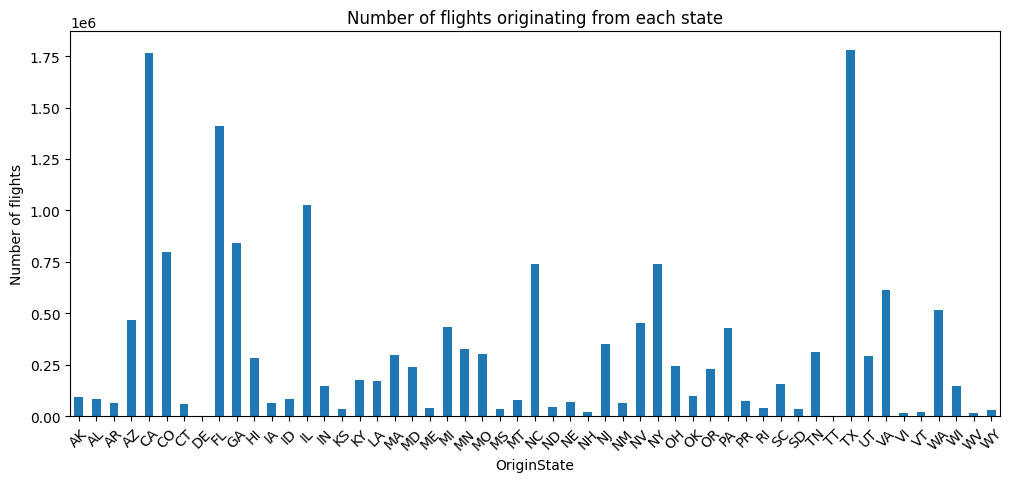

In [65]:
plt.ylabel("Number of flights")
plt.title("Number of flights originating from each state")
flights["OriginState"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(12, 5)

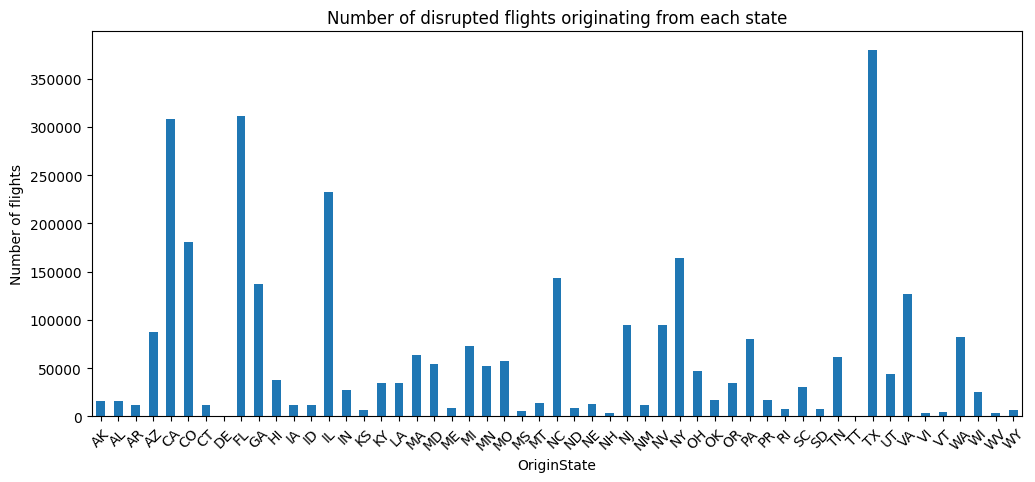

In [66]:
# plot the number of disrupted flights originating from each state
plt.ylabel("Number of flights")
plt.title("Number of disrupted flights originating from each state")
flights[flights["Disruption"] == 1]["OriginState"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(12, 5)

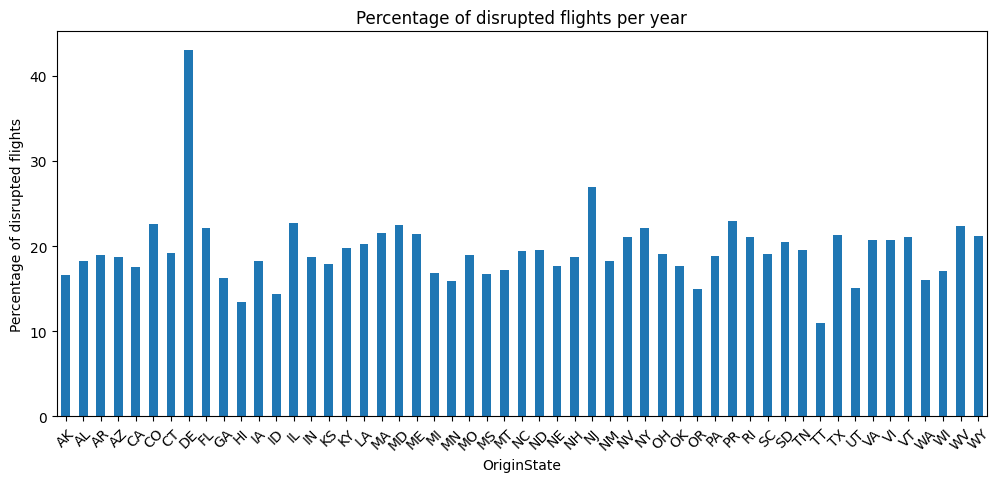

In [67]:
plt.ylabel("Percentage of disrupted flights")
plt.title("Percentage of disrupted flights per year")
(flights[flights["Disruption"] == 1]["OriginState"].value_counts().sort_index() / 
    flights["OriginState"].value_counts().sort_index() * 100).plot(kind="bar")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(12, 5)

- There are too many states to encode so it would be reasonble to try find potential groupings
    - Attempting to do this with US census data of population and groups from 2020-2023
        - As the last full year from the given dataset is from 2021, the population data from this year is used below: 

In [68]:
# Data from https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html

state_data = pandas.read_csv("NST-EST2023-ALLDATA.csv")

pandas.set_option('display.max_columns', None)

# POPESTIMATE2021 is chosen as it is the latest year for the dataset with full data
state_data = state_data[["NAME", "REGION", "POPESTIMATE2021"]]


def lookup_state_abbr(name):
    state = us.states.lookup(name)
    if state is not None:
        return state.abbr
    else:
        return name

state_data["NAME"] = state_data["NAME"].apply(lookup_state_abbr).str.strip()


display(state_data)

,NAME,REGION,POPESTIMATE2021
0,United States,0,332048977
1,Northeast Region,1,57243423
2,New England,1,15106108
3,Middle Atlantic,1,42137315
4,Midwest Region,2,68850246
...,...,...,...
61,WA,4,7741433
62,WV,3,1785249
63,WI,2,5879978
64,WY,4,579548


In [69]:
duplicate_indices = state_data.index[state_data.index.duplicated()]

flights = flights.merge(state_data, left_on='OriginState', right_on='NAME', how='left')
flights.drop(columns=['NAME'], inplace=True)


There is no population data from the cenus for the US Virgin Islands or Trust Territories, therefore this data is filled in from Wikipedia information

In [70]:
flights["REGION"] = flights["REGION"].fillna("X")

In [71]:
# US Virgin Island population estimate is taken from April 1, 2020 from https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
flights.loc[flights["OriginState"] == "VI", "POPESTIMATE2021"] = 87146

In [72]:
# List all unique Origin and OriginCityName of the dataframe where POPESTIMATE2021 is missing
print(flights[flights["POPESTIMATE2021"].isna()]["OriginCityName"].unique())

['Guam, TT' 'Saipan, TT' 'Pago Pago, TT' 'Rota, TT']


Guam, Pago Pago, Rota & Saipan are a part of the territories of Guam, American Samoa, and the Norhtern Marina Islands respectively. Thefore it would be useful to fill the data on the average population of these territories

In [73]:
# Guam, American Som
guam_population = 153836
american_samoa_population = 49710
norhtern_mariana_islands_population = 47329

avg_TT_population = (guam_population + american_samoa_population + norhtern_mariana_islands_population) / 3

In [74]:
flights.loc[flights["OriginState"] == "TT", "POPESTIMATE2021"] = avg_TT_population


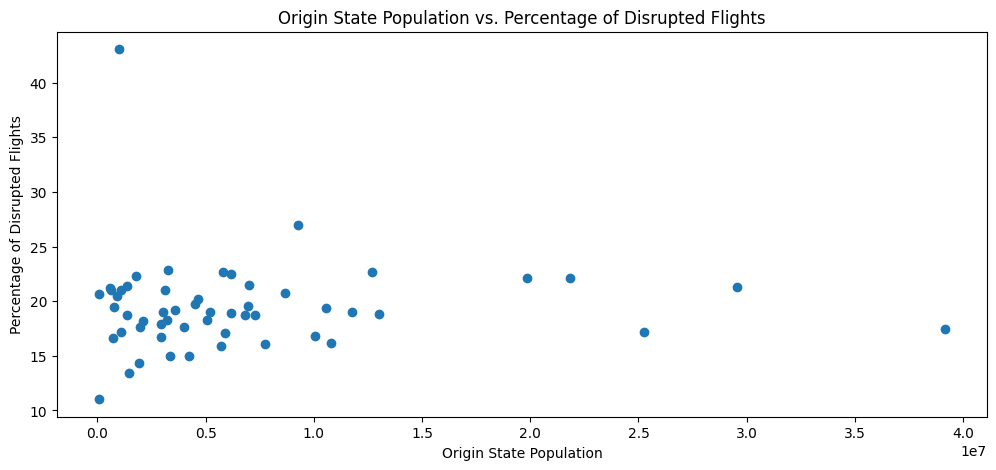

In [75]:
# Calculate the percentage of disrupted flights for each population bucket
disrupted_flights_by_population = flights.groupby("POPESTIMATE2021")["Disruption"].mean() * 100

# Plot the scatter plot
plt.figure(figsize=(12, 5))
plt.scatter(disrupted_flights_by_population.index, disrupted_flights_by_population.values)
plt.title('Origin State Population vs. Percentage of Disrupted Flights')
plt.xlabel('Origin State Population')
plt.ylabel('Percentage of Disrupted Flights')
plt.show()

<h3>Grouping states by region</h3>

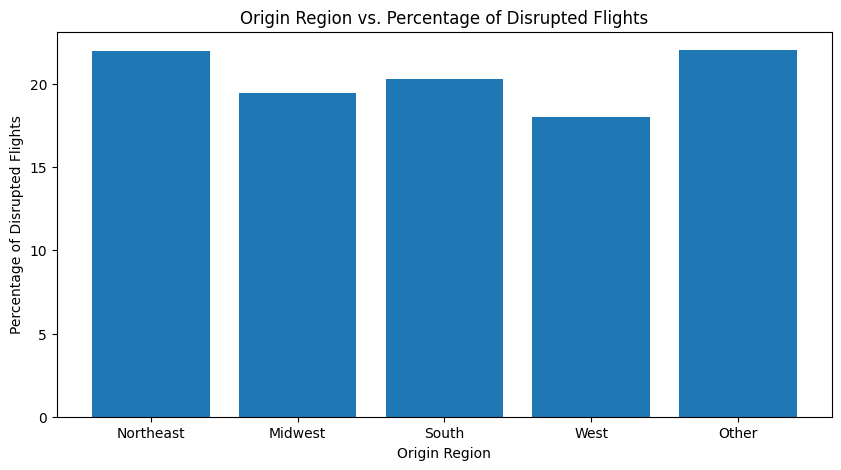

In [76]:
disrupted_flights_by_population = flights.groupby("REGION")["Disruption"].mean() * 100

# Plot the scatter plot
plt.figure(figsize=(10, 5))
plt.bar(disrupted_flights_by_population.index, disrupted_flights_by_population.values)
plt.title('Origin Region vs. Percentage of Disrupted Flights')
plt.xlabel('Origin Region')
plt.ylabel('Percentage of Disrupted Flights')
plt.xticks([0, 1, 2, 3, 4], ["Northeast", "Midwest", "South", "West", "Other"])
plt.show()

Observations:
- There appears to be some difference in percentage of disrupted flights with the Northeast being slightly above average and the West being slightly below the average
- No clear trend amongst the population size and percentage of disruptions


## Check for Missing values

In [77]:
attributes = ["Year", "Month", "Operating_Airline", "DepTimeBlk", "OriginAirportID", "DestAirportID", "Distance", "REGION", "Disruption"]


flights = flights[attributes]

In [78]:
# Find if any of the columns have missing values
flights.isna().sum()

Year                 0
Month                0
Operating_Airline    0
DepTimeBlk           0
OriginAirportID      0
DestAirportID        0
Distance             0
REGION               0
Disruption           0
dtype: int64

In [79]:
flights.dtypes


Year                  int64
Month                 int64
Operating_Airline    object
DepTimeBlk           object
OriginAirportID       int64
DestAirportID         int64
Distance              int64
REGION               object
Disruption             bool
dtype: object

In [80]:
# Convert columns to the correct data type
flights["Year"] = flights["Year"].astype('category')
flights["Month"] = flights["Month"].astype('category')
flights["Operating_Airline"] = flights["Operating_Airline"].astype('category')
flights["DepTimeBlk"] = flights["DepTimeBlk"].astype('category')
flights["OriginAirportID"] = flights["OriginAirportID"].astype('category')
flights["DestAirportID"] = flights["DestAirportID"].astype('category')
flights["REGION"] = flights["REGION"].astype('category')

In [81]:
flights.dtypes

Year                 category
Month                category
Operating_Airline    category
DepTimeBlk           category
OriginAirportID      category
DestAirportID        category
Distance                int64
REGION               category
Disruption               bool
dtype: object

In [82]:
flights

,Year,Month,Operating_Airline,DepTimeBlk,OriginAirportID,DestAirportID,Distance,REGION,Disruption
0,2020,9,OH,1900-1959,14100,11267,477,1,False
1,2020,9,OH,1900-1959,14100,11267,477,1,True
2,2020,9,OH,1900-1959,14100,11267,477,1,False
3,2020,9,OH,1900-1959,14100,11267,477,1,False
4,2020,9,OH,1900-1959,14100,11267,477,1,False
...,...,...,...,...,...,...,...,...,...
16959489,2018,9,ZW,1400-1459,14711,12264,133,1,False
16959490,2018,9,ZW,1200-1259,12264,11995,239,3,False
16959491,2018,9,ZW,1000-1059,11612,13930,272,2,False
16959492,2018,9,ZW,1400-1459,13930,12197,738,2,False


- Year, Month, and DepTimeBlk have some form of ordering so ordinal encoding seems appropriate
- Given that there are over 10 features for airline and airports, one-hot-coding would drastically affect the computational complexity of training the models. One method of dealing with this is through target encoding as it replaces these feature's categories with a number derived from the target
- As there are very few flights that travel greater than 2,750 miles, distance is capped at 2,750 before being normalised
- Given that there are only 5 regions, one-hot-encoding seems appropriate

In [83]:
'''
Year -> Ordinal
Month -> Ordinal
Operating_Airline -> Target Encode
DepTimeBlk -> ConvertToOrdinal
OriginAirportID -> Target Encode
DestAirportID -> Target Encode
Distance -> Max at 2750 then normalize
REGION -> One hot encode
'''


target_columns = ["Operating_Airline", "OriginAirportID", "DestAirportID"]
one_hot_columns = ["REGION"]
numerical_columns = ["Distance"]

year_order = ["2018", "2019", "2020", "2021", "2022"]
time_order = ["0001-0559", "0600-0659", "0700-0759", "0800-0859", "0900-0959", "1000-1059", "1100-1159", 
              "1200-1259", "1300-1359", "1400-1459", "1500-1559", "1600-1659", "1700-1759", "1800-1859", 
              "1900-1959", "2000-2059", "2100-2159", "2200-2259", "2300-2359"]

target_transformer = Pipeline(steps=[
    ('target_encode', TargetEncoder())
])

year_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[year_order]))
])

time_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[time_order]))
])

one_hot_transformer = Pipeline(steps=[
    ('one_hot', OneHotEncoder())
])

numerical_transformer = Pipeline(steps=[
    ('cap_distance', FunctionTransformer(lambda x: x.clip(upper=2750))),
    ('scale_distance', MinMaxScaler())
])

pipeline = ColumnTransformer(
    transformers=[
        ('target', target_transformer, target_columns),
        ('year_tranformer', year_transformer, ['Year']),
        ('time_transformer', time_transformer, ['DepTimeBlk']),
        ('one_hot', one_hot_transformer, one_hot_columns),
        ('numerical', numerical_transformer, numerical_columns)
    ],
    remainder='passthrough')


# Split features and target variable
X = flights.drop('Disruption', axis=1)
y = flights['Disruption']

X_processed = pipeline.fit_transform(X, y)

print(X.iloc[0])
print(X_processed[0])

/home/ejml1/.local/lib/python3.9/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/ejml1/.local/lib/python3.9/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/ejml1/.local/lib/python3.9/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

Year                      2020
Month                        9
Operating_Airline           OH
DepTimeBlk           1900-1959
OriginAirportID          14100
DestAirportID            11267
Distance                   477
REGION                       1
Name: 0, dtype: object
[ 0.19919057  0.19390515  0.19691239  2.         14.          1.
  0.          0.          0.          0.          0.16861741  9.        ]


In [84]:
kfold = KFold(n_splits=5, shuffle=True, random_state=5059)

tree_classifier = DecisionTreeClassifier(random_state=5059)
random_forest_classifier = RandomForestClassifier(random_state=5059)
k_nearest_neighbours_classifier = KNeighborsClassifier()

In [85]:
tree_scores = cross_val_score(tree_classifier, X_processed, y, cv=kfold, scoring='balanced_accuracy')

In [86]:
random_forest_scores = cross_val_score(random_forest_classifier, X_processed, y, cv=kfold, scoring='balanced_accuracy')


KeyboardInterrupt: 

In [ ]:
k_nearest_neighbours_scores = cross_val_score(k_nearest_neighbours_classifier, X_processed, y, cv=kfold, scoring='balanced_accuracy')

In [87]:
print("Decision Tree Cross-validation Scores:", tree_scores)
print("Mean balanced accuracy:", tree_scores.mean())
print("Standard deviation of balanced accuracy:", tree_scores.std())
print()

# print("Random Forest Cross-validation Scores:", random_forest_scores)
# print("Mean balanced accuracy:", random_forest_scores.mean())
# print("Standard deviation of balanced accuracy:", random_forest_scores.std())
# print()

# print("K Nearest Neighbours Cross-validation Scores:", k_nearest_neighbours_scores)
# print("Mean balanced accuracy:", k_nearest_neighbours_scores.mean())
# print("Standard deviation of balanced accuracy:", k_nearest_neighbours_scores.std())

Decision Tree Cross-validation Scores: [0.55608374 0.55611526 0.55612067 0.55614953 0.55647269]
Mean balanced accuracy: 0.5561883770305402
Standard deviation of balanced accuracy: 0.00014368036075182588



Given that the three classifiers used have next to no difference in balanced accuracy, I will choose the DecisionTreeClassifier as my main model due to the speed of training time

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=5059)

In [89]:
tree_classifier.fit(X_train, y_train)

# Get feature importances
importances = tree_classifier.feature_importances_

In [90]:
y_pred = tree_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
bal_accuracy = balanced_accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Balanced Accuracy:", bal_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8026545012100891
Balanced Accuracy: 0.5560837352482573
Precision: 0.4923378632739744
Recall: 0.1499671302452774
F1-score: 0.22990478732461125


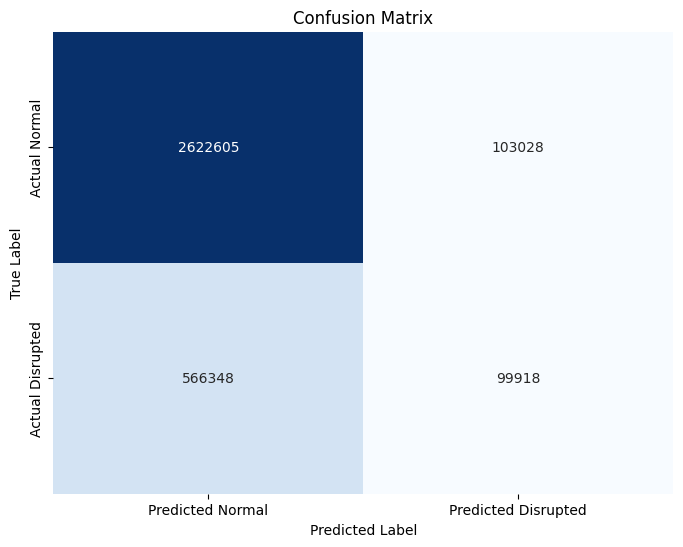

In [91]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Normal', 'Predicted Disrupted'], 
            yticklabels=['Actual Normal', 'Actual Disrupted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

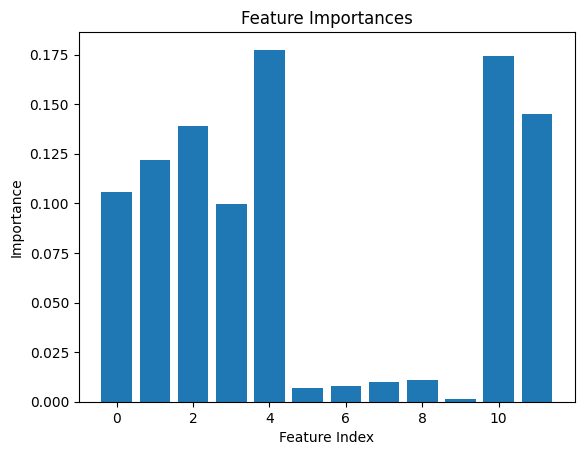

In [92]:
indices = range(len(importances))

plt.bar(indices, importances)

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances')

plt.show()

# Evaluate Performance on Test

In [ ]:
print(f'Number of N/A values in Disruption: {flights_test["Disruption"].isna().sum()}')

Number of na values in Disruption: 3


Drop empty disruption values

In [ ]:
# flights_test = flights_test.dropna(subset=["Disruption"])

In [ ]:

# # Merge the state data with the flights_test dataframe
# X_test = flights_test.merge(state_data, left_on='OriginState', right_on='NAME', how='left')

# # # US Virgin Island population estimate is taken from April 1, 2020 from https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
# X_test.loc[X_test["OriginState"] == "VI", "POPESTIMATE2021"] = 87146

# X_test.loc[X_test["OriginState"] == "TT", "POPESTIMATE2021"] = avg_TT_population

# X_test["REGION"] = X_test["REGION"].fillna("X")
 
# X_test = X_test[attributes]

# # # Convert columns to the correct data type
# X_test["Year"] = X_test["Year"].astype('category')
# X_test["Month"] = X_test["Month"].astype('category')
# X_test["Operating_Airline"] = X_test["Operating_Airline"].astype('category')
# X_test["DepTimeBlk"] = X_test["DepTimeBlk"].astype('category')
# X_test["OriginAirportID"] = X_test["OriginAirportID"].astype('category')
# X_test["DestAirportID"] = X_test["DestAirportID"].astype('category')
# X_test["REGION"] = X_test["REGION"].astype('category')


# # Split features and target variable
# y_test = X_test['Disruption']
# X_test = X_test.drop('Disruption', axis=1)

# X_test_processed = pipeline.transform(X_test)

/home/ejml1/.local/lib/python3.9/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/ejml1/.local/lib/python3.9/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)


In [ ]:
# y_pred = tree_classifier.predict(X_test_processed)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the evaluation metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

Accuracy: 0.7003445687772926
Precision: 0.2626816106268161
Recall: 0.2670042194092827
F1-score: 0.26482527725465577


In [ ]:
# tree.plot_tree(tree_classifier, filled=True)

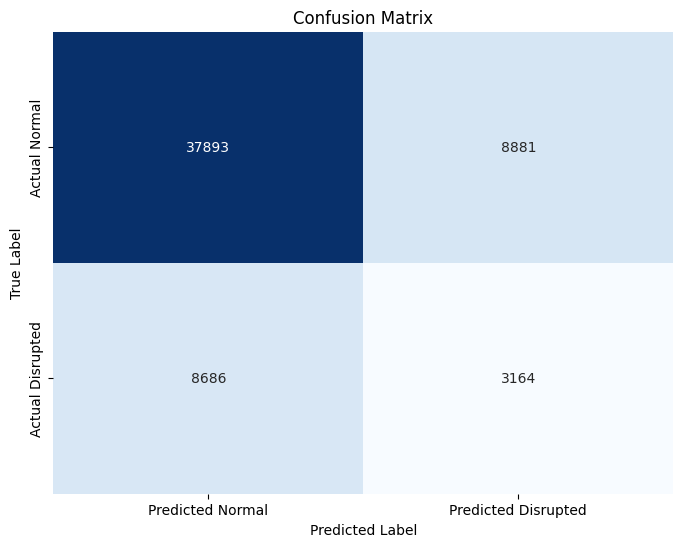

In [ ]:
# cm = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=['Predicted Normal', 'Predicted Disrupted'], 
#             yticklabels=['Actual Normal', 'Actual Disrupted'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()